In [1]:
import os
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colormaps

## Utility Functions

In [3]:
def parse_time(text):
    # 0:30.42 sec --> 0.5 (in minutes)
    # or 1:34.56 sec --> 1.57 (in minutes)
    # or 1:12:34.13 sec --> 72.57 (in minutes)
    if text.endswith(" sec"):
        text = text.split(" ")[0]  # Remove ' sec'
    parts = text.split(":")
    if len(parts) == 2:
        # Format: mm:ss
        minutes = float(parts[0])
        seconds = float(parts[1])
        return round(minutes + seconds / 60, 2)
    elif len(parts) == 3:
        # Format: hh:mm:ss
        hours = float(parts[0])
        minutes = float(parts[1])
        seconds = float(parts[2])
        return round(hours * 60 + minutes + seconds / 60, 2)

def parse_catboost_time(text):
    """
    Converts CatBoost time strings like '2.72s', '1m 44s', '5m 20s' to minutes (float).
    """
    text = text.strip()
    if text.endswith('ms'):
        # Format: '23.40ms'
        ms = float(text[:-2])
        return round(ms / 1000 / 60, 6)
    elif text.endswith('s') and not any(x in text for x in ['m', 'h']):
        # Format: '2.72s'
        seconds = float(text[:-1])
        return round(seconds / 60, 4)
    elif 'm' in text and 's' in text:
        # Format: '1m 44s'
        parts = text.split('m')
        minutes = float(parts[0])
        seconds = float(parts[1].replace('s', '').strip())
        return round(minutes + seconds / 60, 4)
    elif 'h' in text:
        # Format: '1h 12m 34s'
        h, rest = text.split('h')
        hours = float(h)
        if 'm' in rest and 's' in rest:
            m, s = rest.split('m')
            minutes = float(m)
            seconds = float(s.replace('s', '').strip())
            return round(hours * 60 + minutes + seconds / 60, 4)
        elif 'm' in rest:
            minutes = float(rest.replace('m', '').strip())
            return round(hours * 60 + minutes, 4)
    elif 'm' in text:
        # Format: '5m'
        minutes = float(text.replace('m', '').strip())
        return round(minutes, 4)
    return None

def convert_units(df):
    """
    Converts the specified columns in the DataFrame to appropriate units.
    """
    # Create a copy
    df = df.copy()

    # Ensure columns exist before attempting conversion
    if 'num_nodes' in df.columns:
        # 123456 --> 123.4 (in thousands)
        df['num_nodes'] = df['num_nodes'] / 1000
        df['num_nodes'] = df['num_nodes'].round(1)  # Round to 1 decimal places

    if 'num_edges' in df.columns:
        # 123456 --> 123.4 (in thousands)
        df['num_edges'] = df['num_edges'] / 1000
        df['num_edges'] = df['num_edges'].round(1)  # Round to 1 decimal places

    if 'train_data_size' in df.columns:
        # 880700 --> 880.7 (in thousands)
        df['train_data_size'] = df['train_data_size'] / 1000  # Convert to thousands
        df['train_data_size'] = df['train_data_size'].round(1)  # Round to 1 decimal places

    if 'test_data_size' in df.columns:
        # 880700 --> 880.7 (in thousands)
        df['test_data_size'] = df['test_data_size'] / 1000
        df['test_data_size'] = df['test_data_size'].round(1)  # Round to 1 decimal places

    if 'model_params' in df.columns:
        # 123456 --> 123.4 (in thousands)
        df['model_params'] = df['model_params'] / 1000  # Convert to thousands
        df['model_params'] = df['model_params'].round(1)  # Round to 1 decimal places

    if 'model_size' in df.columns:
        # "12 MB" --> 12 (in MB)
        df['model_size'] = df['model_size'].astype(str).str.replace(" MB", "").astype(float)

    if 'train_mre' in df.columns:
        # "5.12%" --> 5.12 (in percentage)
        df['train_mre'] = df['train_mre'].astype(str).str.rstrip('%')  # Remove % sign
        df['train_mre'] = df['train_mre'].astype(float)  # Convert to float
        df['train_mre'] = df['train_mre'].round(2)

    if 'test_mre' in df.columns:
        # "0.12%" --> 0.12 (in percentage)
        df['test_mre'] = df['test_mre'].astype(str).str.rstrip('%')  # Remove % sign
        df['test_mre'] = df['test_mre'].astype(float)  # Convert to float
        df['test_mre'] = df['test_mre'].round(2)

    if 'precomputation_time' in df.columns:
        # "12.23 minutes" --> 12.23 (in minutes)
        df['precomputation_time'] = df['precomputation_time'].astype(str).map(lambda x: x.split(" ")[0]).astype(float)  # Convert to float
        df['precomputation_time'] = df['precomputation_time'].round(2)

    if 'train_query_time' in df.columns:
        # "1.34 microseconds" --> 1.34 (in microseconds)
        df['train_query_time'] = df['train_query_time'].astype(str) \
                                    .map(lambda x: x.split(" ")[0]).astype(float)  # Convert to float
        # df['train_query_time'] = df['train_query_time'].round(2)

    if 'train_evaluation_time' in df.columns:
        # "0.08 minutes" --> 0.08 (in minutes)
        df['train_evaluation_time'] = df['train_evaluation_time'].astype(str) \
                                        .map(lambda x: x.split(" ")[0]).astype(float)

    if 'test_query_time' in df.columns:
        # "1.34 microseconds" --> 1.34 (in microseconds)
        df['test_query_time'] = df['test_query_time'].astype(str) \
                                    .map(lambda x: x.split(" ")[0]).astype(float)  # Convert to float
        # df['test_query_time'] = df['test_query_time'].round(2)

    if 'test_evaluation_time' in df.columns:
        # "0.08 minutes" --> 0.08 (in minutes)
        df['test_evaluation_time'] = df['test_evaluation_time'].astype(str) \
                                        .map(lambda x: x.split(" ")[0]).astype(float)

    if 'max_cpu_memory' in df.columns:
        # "840376 KB" --> 0.84 (in GB)
        df['max_cpu_memory'] = df['max_cpu_memory'].astype(str) \
                                .map(lambda x: int(x.split(" ")[0])/ (1024 * 1024))  # Convert to GB
        df['max_cpu_memory'] = df['max_cpu_memory'].round(2)

    if 'time_elapsed' in df.columns:
        # "0:30.42 sec" --> 0.5 (in minutes)
        # df['time_elapsed'] = df['time_elapsed'].astype(str).str.rstrip(' sec')  # Remove sec
        # df['time_elapsed'] = df['time_elapsed'].map(lambda x: float(x.split(":")[0]) + float(x.split(":")[1])/60)  # Convert to minutes
        # df['time_elapsed'] = df['time_elapsed'].round(2)
        df['time_elapsed'] = df['time_elapsed'].astype(str).map(parse_time)

    # 'average_query_time': '0.62 microseconds'
    if 'average_query_time' in df.columns:
        # "0.62 microseconds" --> 0.62 (in microseconds)
        df['average_query_time'] = df['average_query_time'].astype(str) \
                                        .map(lambda x: x.split(" ")[0]).astype(float)  # Convert to float

    return df

In [63]:
## Version 3 ##

def parse_worker_log(log_file):
    """
    Parses the worker log file and extracts the required information.
    """
    result = {}
    #### Command line arguments ####
    model_class = None
    model_name = None
    data_name = None
    query_name = None
    batch_size_train = None
    batch_size_test = None
    learning_rate = None
    epochs = None
    eval_runs = None
    seed = None
    num_workers = None
    matmul_precision = None
    embedding_dim = None
    p_norm = None
    landmark_selection = None
    gnn_layer = None
    disable_edge_weight = None

    #### Graph statistics ####
    num_nodes = None
    num_edges = None

    #### Train and Test Data Statistics ####
    in_train = None
    train_data_size = None
    test_data_size = None
    train_data_distance_mean = None
    test_data_distance_mean = None

    #### Model Architecture ####
    model_params = None
    loss_function = None
    optimizer = None
    gpu_name = None
    device = None
    precomputation_time = None
    model_size = None

    #### Train Metrics ####
    train_evaluation_time = None
    train_query_time = None
    train_mae = None
    train_mre = None
    train_mre_bucket1 = None
    train_mre_bucket2 = None
    train_mre_bucket3 = None
    train_mre_bucket4 = None
    train_mre_bucket5 = None
    train_loss_history = []
    val_mre_history = []
    time_elapsed_history = []
    epoch_history = []

    #### Test Metrics ####
    test_evaluation_time = None
    test_query_time = None
    test_mae = None
    test_mre = None
    test_mre_bucket1 = None
    test_mre_bucket2 = None
    test_mre_bucket3 = None
    test_mre_bucket4 = None
    test_mre_bucket5 = None

    #### Misc ####
    average_query_time = None

    with open(log_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            #### Command line arguments ####
            # - model_class         : rgnndist2vec
            if re.match(r"  - model_class\s*: ", line) and model_class is None:
                model_class = re.split(r"  - model_class\s*: ", line)[1].strip()
                result['model_class'] = model_class

            # - model_name          : GCN
            if re.match(r"  - model_name\s*: ", line) and model_name is None:
                model_name = re.split(r"  - model_name\s*: ", line)[1].strip()
                result['model_name'] = model_name

            # - data_dir            : ../data/W_Chengdu/
            if re.match(r"  - data_dir\s*: ", line) and data_name is None:
                data_name = re.split(r"  - data_dir\s*: ", line)[1].strip()
                data_name = os.path.basename(os.path.normpath(data_name))  # Get the last part of the path
                result['data_name'] = data_name

            # - query_dir           : ../data/W_Chengdu/real_workload/
            if re.match(r"  - query_dir\s*: ", line) and query_name is None:
                query_name = re.split(r"  - query_dir\s*: ", line)[1].strip()
                query_name = os.path.basename(os.path.normpath(query_name))  # Get the last part of the path
                result['query_name'] = query_name

            # - batch_size_train    : 1024
            if re.match(r"  - batch_size_train\s*: ", line) and batch_size_train is None:
                batch_size_train = re.split(r"  - batch_size_train\s*: ", line)[1].strip()
                batch_size_train = int(batch_size_train)
                result['batch_size_train'] = batch_size_train

            # - batch_size_test     : 1048576
            if re.match(r"  - batch_size_test\s*: ", line) and batch_size_test is None:
                batch_size_test = re.split(r"  - batch_size_test\s*: ", line)[1].strip()
                batch_size_test = int(batch_size_test)
                result['batch_size_test'] = batch_size_test

            # - learning_rate       : 0.001
            if re.match(r"  - learning_rate\s*: ", line) and learning_rate is None:
                learning_rate = re.split(r"  - learning_rate\s*: ", line)[1].strip()
                learning_rate = float(learning_rate)
                result['learning_rate'] = learning_rate

            # - epochs              : 20
            if re.match(r"  - epochs\s*: ", line) and epochs is None:
                epochs = re.split(r"  - epochs\s*: ", line)[1].strip()
                epochs = int(epochs)
                result['epochs'] = epochs

            # - eval_runs           : 10
            if re.match(r"  - eval_runs\s*: ", line) and eval_runs is None:
                eval_runs = re.split(r"  - eval_runs\s*: ", line)[1].strip()
                eval_runs = int(eval_runs)
                result['eval_runs'] = eval_runs

            # - seed                : 42
            if re.match(r"  - seed\s*: ", line) and seed is None:
                seed = re.split(r"  - seed\s*: ", line)[1].strip()
                seed = int(seed)
                result['seed'] = seed

            # - num_workers         : 16
            if re.match(r"  - num_workers\s*: ", line) and num_workers is None:
                num_workers = re.split(r"  - num_workers\s*: ", line)[1].strip()
                num_workers = int(num_workers)
                result['num_workers'] = num_workers

            # - matmul_precision     : medium
            if re.match(r"  - matmul_precision\s*: ", line) and matmul_precision is None:
                matmul_precision = re.split(r"  - matmul_precision\s*: ", line)[1].strip()
                result['matmul_precision'] = matmul_precision

            # - embedding_dim       : 64
            if re.match(r"  - embedding_dim\s*: ", line) and embedding_dim is None:
                embedding_dim = re.split(r"  - embedding_dim\s*: ", line)[1].strip()
                embedding_dim = int(embedding_dim)
                result['embedding_dim'] = embedding_dim

            # - p_norm              : 1
            if re.match(r"  - p_norm\s*: ", line) and p_norm is None:
                p_norm = re.split(r"  - p_norm\s*: ", line)[1].strip()
                p_norm = int(p_norm)
                result['p_norm'] = p_norm

            # - landmark_selection  : random
            if re.match(r"  - landmark_selection\s*: ", line) and landmark_selection is None:
                landmark_selection = re.split(r"  - landmark_selection\s*: ", line)[1].strip()
                result['landmark_selection'] = landmark_selection

            # - gnn_layer           : gcn
            if re.match(r"  - gnn_layer\s*: ", line) and gnn_layer is None:
                gnn_layer = re.split(r"  - gnn_layer\s*: ", line)[1].strip()
                result['gnn_layer'] = gnn_layer

            # - disable_edge_weight : True
            if re.match(r"  - disable_edge_weight\s*: ", line) and disable_edge_weight is None:
                disable_edge_weight = re.split(r"  - disable_edge_weight\s*: ", line)[1].strip()
                disable_edge_weight = disable_edge_weight == "True"
                result['disable_edge_weight'] = disable_edge_weight

            #### Check graph statistics ####
            if num_nodes is None and line.startswith("  - No. of nodes: "):
                num_nodes = line.split("  - No. of nodes: ")[1].strip()
                num_nodes = int(num_nodes)
                result['num_nodes'] = num_nodes

            if num_edges is None and line.startswith("  - No. of edges: "):
                num_edges = line.split("  - No. of edges: ")[1].strip()
                num_edges = int(num_edges)
                result['num_edges'] = num_edges

            #### Train Data Statistics ####
            # Check train dataset loading
            if line.startswith("Train dataset...") or line.startswith("Loading train dataset..."):
                in_train = True

            if line.startswith("Augmented Train dataset...") or line.startswith("Loading train dataset..."):
                in_train = True
                train_data_size = None
                train_data_distance_mean = None

            #   - No. of samples: 15226
            if train_data_size is None and in_train and line.startswith("  - No. of samples: "):
                train_data_size = line.split("  - No. of samples: ")[1].strip()
                train_data_size = int(train_data_size)
                result['train_data_size'] = train_data_size

            # - Mean/Std distance: 15653.64/14355.13
            if train_data_distance_mean is None and in_train and line.startswith("  - Mean/Std distance: "):
                train_data_distance_mean = line.split("  - Mean/Std distance: ")[1].strip()
                train_data_distance_mean = train_data_distance_mean.split("/")[0].strip()
                train_data_distance_mean = float(train_data_distance_mean)
                result['train_data_distance_mean'] = train_data_distance_mean

            #### Test Data Statistics ####
            # Check test dataset loading
            if line.startswith("Test dataset...") or line.startswith("Loading test dataset..."):
                in_train = False

            #   - No. of samples: 15226
            if test_data_size is None and not in_train and line.startswith("  - No. of samples: "):
                test_data_size = line.split("  - No. of samples: ")[1].strip()
                test_data_size = int(test_data_size)
                result['test_data_size'] = test_data_size

            # - Mean/Std distance: 15653.64/14355.13
            if test_data_distance_mean is None and not in_train and line.startswith("  - Mean/Std distance: "):
                test_data_distance_mean = line.split("  - Mean/Std distance: ")[1].strip()
                test_data_distance_mean = test_data_distance_mean.split("/")[0].strip()
                test_data_distance_mean = float(test_data_distance_mean)
                result['test_data_distance_mean'] = test_data_distance_mean

            #### Model Architecture ####
            # Model parameters size: 34368
            if model_params is None and line.startswith("Model parameters size: "):
                model_params = line.split("Model parameters size: ")[1].strip()
                model_params = int(model_params)
                result['model_params'] = model_params

            # Loss function: MSELoss()
            if loss_function is None and line.startswith("Loss function: "):
                loss_function = line.split("Loss function: ")[1].strip()
                result['loss_function'] = loss_function.strip("()")

            # Optimizer: Adam (
            if optimizer is None and line.startswith("Optimizer: "):
                optimizer = line.split("Optimizer: ")[1].strip().split()[0]
                result['optimizer'] = optimizer

            # GPU Detected: NVIDIA A30
            if gpu_name is None and line.startswith("GPU Detected: "):
                gpu_name = line.split("GPU Detected: ")[1].strip()
                result['gpu_name'] = gpu_name

            # Using Device: cuda
            if device is None and line.startswith("Using Device: "):
                device = line.split("Using Device: ")[1].strip()
                result['device'] = device

            # Precomputation time: 2.62 minutes
            if precomputation_time is None and line.startswith("Precomputation time: "):
                precomputation_time = line.split("Precomputation time: ")[1].strip()
                result['precomputation_time'] = precomputation_time

            #   - Model size: 6.57 MB
            if model_size is None and line.startswith("  - Model size: "):
                model_size = line.split("  - Model size: ")[1].strip()
                result['model_size'] = model_size

            #### Train Metrics ####
            # Check train evaluation metrics
            if line.startswith("Evaluation on train Finished!"):
                in_train = True

            # Evaluation time: 0.08 minutes
            if train_evaluation_time is None and in_train and line.startswith("Evaluation time: "):
                train_evaluation_time = line.split("Evaluation time: ")[1].strip()
                result['train_evaluation_time'] = train_evaluation_time

            # Query time per sample: 1.47 microseconds
            if train_query_time is None and line.startswith("Query time per sample: "):
                train_query_time = line.split("Query time per sample: ")[1].strip()
                result['train_query_time'] = train_query_time

            # Mean Absolute Error: 8616.94
            if train_mae is None and line.startswith("Mean Absolute Error: "):
                train_mae = line.split("Mean Absolute Error: ")[1].strip()
                result['train_mae'] = float(train_mae)

            # Mean Relative Error: 90.12%
            if train_mre is None and line.startswith("Mean Relative Error: "):
                train_mre = line.split("Mean Relative Error: ")[1].strip()
                result['train_mre'] = train_mre

            # Bucket 1: 11 - 32939, Local MRE: 5.96%, Fraction of data samples in this bucket: 56.56%
            if train_mre_bucket1 is None and in_train and line.startswith("Bucket 1: "):
                train_mre_bucket1 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket1'] = float(train_mre_bucket1[:-1])  # Remove % sign
            if train_mre_bucket2 is None and in_train and line.startswith("Bucket 2: "):
                train_mre_bucket2 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket2'] = float(train_mre_bucket2[:-1])  # Remove % sign
            if train_mre_bucket3 is None and in_train and line.startswith("Bucket 3: "):
                train_mre_bucket3 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket3'] = float(train_mre_bucket3[:-1])  # Remove % sign
            if train_mre_bucket4 is None and in_train and line.startswith("Bucket 4: "):
                train_mre_bucket4 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket4'] = float(train_mre_bucket4[:-1])  # Remove % sign
            if train_mre_bucket5 is None and in_train and line.startswith("Bucket 5: "):
                train_mre_bucket5 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket5'] = float(train_mre_bucket5[:-1])  # Remove % sign

            # With VALIDATION
            # Epoch:  1/12000, Time elapsed/remaining/total: 0.09/1084.90/1084.99 min, Train Loss:   0.16734625, Val MRE: 9.94%
            # Without VALIDATION
            # Epoch:  1/2, Time elapsed/remaining/total: 0.03/0.03/0.07 min, Train Loss:   2800323.56
            if model_class != "catboost" and "Time elapsed/remaining/total:" in line:
                epoch_match = re.search(r"Epoch:\s+(\d+)/\d+", line)
                time_elapsed_match = re.search(r"Time elapsed/remaining/total:\s+([\d.]+)/", line)
                train_loss_match = re.search(r"Train Loss:\s+([\d.]+)", line)
                val_mre_match = re.search(r"Val MRE:\s+([\d.]+)%", line)

                if epoch_match:
                    epoch = int(epoch_match.group(1))  # current epoch
                    epoch_history.append(epoch)
                    result['epoch_history'] = epoch_history

                if time_elapsed_match:
                    time_elapsed = float(time_elapsed_match.group(1))  # in minutes
                    time_elapsed_history.append(time_elapsed)
                    result['time_elapsed_history'] = time_elapsed_history

                if train_loss_match:
                    train_loss = float(train_loss_match.group(1))  # train loss
                    train_loss_history.append(train_loss)
                    result['train_loss_history'] = train_loss_history

                if val_mre_match:
                    val_mre = float(val_mre_match.group(1))  # val mre in %
                    val_mre_history.append(val_mre)
                    result['val_mre_history'] = val_mre_history
                    result['val_best_mre'] = min(val_mre_history)  # Best val mre so far

            # With VALIDATION
            # 100:	learn: 0.0687108	test: 0.0688295	best: 0.0687909 (99)	total: 2.72s	remaining: 5m 20s
            # 4000:	learn: 0.0192793	test: 0.0226579	best: 0.0226579 (4000)	total: 1m 44s	remaining: 3m 28s
            # Without VALIDATION
            # 100:    learn: 0.6710179        total: 2.64s    remaining: 10.4s
            elif model_class == "catboost" and "total:" in line and "remaining:" in line:
                epoch_match = re.search(r"(\d+):\s+learn:", line)
                time_elapsed_match = re.search(r"total:\s*(.*?)\s*remaining:", line)
                train_loss_match = re.search(r"learn:\s+([\d.]+)", line)
                val_mre_match = re.search(r"test:\s+([\d.]+)", line)

                if epoch_match:
                    epoch = int(epoch_match.group(1))  # current epoch
                    epoch_history.append(epoch)
                    result['epoch_history'] = epoch_history

                if time_elapsed_match:
                    time_elapsed_str = time_elapsed_match.group(1)  # e.g., '2.72s' or '1m 44s'
                    time_elapsed = parse_catboost_time(time_elapsed_str)  # in minutes
                    time_elapsed_history.append(time_elapsed)
                    result['time_elapsed_history'] = time_elapsed_history

                if train_loss_match:
                    train_loss = float(train_loss_match.group(1))  # train loss
                    train_loss_history.append(train_loss)
                    result['train_loss_history'] = train_loss_history

                if val_mre_match:
                    val_mre = round(float(val_mre_match.group(1))*100, 2)  # val mre in %
                    val_mre_history.append(val_mre)
                    result['val_mre_history'] = val_mre_history
                    result['val_best_mre'] = min(val_mre_history)  # Best val mre so far

            #### Test Metrics ####
            # Check test evaluation metrics
            if line.startswith("Evaluation on test Finished!"):
                in_train = False

            # Evaluation time: 0.08 minutes
            if test_evaluation_time is None and not in_train and line.startswith("Evaluation time: "):
                test_evaluation_time = line.split("Evaluation time: ")[1].strip()
                result['test_evaluation_time'] = test_evaluation_time

            # Query time per sample: 1.47 microseconds
            if test_query_time is None and not in_train and line.startswith("Query time per sample: "):
                test_query_time = line.split("Query time per sample: ")[1].strip()
                result['test_query_time'] = test_query_time

            # Mean Absolute Error: 8616.94
            if test_mae is None and not in_train and line.startswith("Mean Absolute Error: "):
                test_mae = line.split("Mean Absolute Error: ")[1].strip()
                result['test_mae'] = float(test_mae)

            # Mean Relative Error: 90.12%
            if test_mre is None and not in_train and line.startswith("Mean Relative Error: "):
                test_mre = line.split("Mean Relative Error: ")[1].strip()
                result['test_mre'] = test_mre

            # Bucket 1: 11 - 32939, Local MRE: 5.96%, Fraction of data samples in this bucket: 56.56%
            if test_mre_bucket1 is None and not in_train and line.startswith("Bucket 1: "):
                test_mre_bucket1 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket1'] = float(test_mre_bucket1[:-1])  # Remove % sign
            if test_mre_bucket2 is None and not in_train and line.startswith("Bucket 2: "):
                test_mre_bucket2 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket2'] = float(test_mre_bucket2[:-1])  # Remove % sign
            if test_mre_bucket3 is None and not in_train and line.startswith("Bucket 3: "):
                test_mre_bucket3 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket3'] = float(test_mre_bucket3[:-1])  # Remove % sign
            if test_mre_bucket4 is None and not in_train and line.startswith("Bucket 4: "):
                test_mre_bucket4 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket4'] = float(test_mre_bucket4[:-1])  # Remove % sign
            if test_mre_bucket5 is None and not in_train and line.startswith("Bucket 5: "):
                test_mre_bucket5 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket5'] = float(test_mre_bucket5[:-1])  # Remove % sign

            #### Misc ####
            # [Eval Run] Average query time per sample: 0.32 microseconds
            if average_query_time is None and line.startswith("[Eval Run] Average query time per sample: "):
                average_query_time = line.split("[Eval Run] Average query time per sample: ")[1].strip()
                result['average_query_time'] = average_query_time

    # Compute last_train_epoch from epoch_history
    result['last_train_epoch'] = int(epoch_history[-1]) if epoch_history else None
    return result

def parse_master_log(file_path):
    """
    Parses the main log file, extracts relevant information,
    and combines it with data from worker training logs.
    """
    global_results = []
    current_result = {}

    #### Extract job_id from the file name ####
    # results/expt25-workload/train-master-9397567.log
    job_id = os.path.basename(file_path).split("-")[1].split(".")[0]
    current_result['job_id'] = job_id

    # Read the main log file
    with open(file_path, 'r') as main_file:
        for line in tqdm(main_file):
            # PYTHON_COMMAND: python train_geodnn.py --model_name GeoDNN --data_name Rome --data_strategy landmark \
            # --data_version v1-landmark --training_epochs 20 --seed 42 --experiment_name expt18-train-medium-v1-landmark
            if line.startswith("PYTHON_COMMAND: "):
                current_result = {}  # Start a new dictionary
                python_command = line.split("PYTHON_COMMAND: ")[1].strip()
                current_result['python_command'] = python_command

            # LOG_FILE: ../results/logs/expt18-train-medium-v1-landmark/train_GeoDNN_Rome.log
            elif line.startswith("LOG_FILE: "):
                log_output_path = line.split("LOG_FILE: ")[1].strip()
                current_result['log_output'] = log_output_path
                ## Extract expt_name, model_name, and dataset_variant from the log file path
                # LOG_FILE="${LOG_DIR}/${EXPT_NAME}/train_${model_name}_${dataset}.log"
                expt_name = os.path.basename(os.path.dirname(os.path.normpath(log_output_path)))  # Extract the directory name
                current_result['expt_name'] = expt_name

                ## Parse the worker log file and combine results
                worker_result = parse_worker_log(log_output_path)
                current_result = {**current_result, **worker_result}  # Merge dictionaries

            # Max CPU Memory: 2084488 KB
            elif line.startswith("Max CPU Memory: "):
                memory_kb = line.split("Max CPU Memory: ")[1].strip()
                current_result['max_cpu_memory'] = memory_kb

            # Time Elapsed: 1:28.28 sec
            elif line.startswith("Time Elapsed: "):
                time_elapsed = line.split("Time Elapsed: ")[1].strip()
                current_result['time_elapsed'] = time_elapsed
                global_results.append(current_result)  # Append to the global list

    return pd.DataFrame(global_results)

## Parse Logs

In [64]:
# # Paper-results
# master_file_names = glob("../results/v36-real_workload_perturb_500k/train-master-9800359.log") \
#     + glob("../results/v39-real_workload_perturb_500k/train-master-*.log")

# Post-testing
# master_file_names = glob("../results/v61-gpu-v1/train-master-*.log")
# master_file_names = glob("../results/v61-gpu-*/train-master-*.log")
master_file_names = glob("../results/v62-gpu-v1/train-master-*.log")
# master_file_names = glob("../results/v63-gpu-*/train-master-*.log")

df_list = [convert_units(parse_master_log(f)) for f in master_file_names]

for df in df_list:
    print(df.shape)

# concat df1 and df2
# df = pd.concat([df1, df2], ignore_index=True)
df = pd.concat(df_list, ignore_index=True)
print("Shape: ", df.shape)
print("Datasets: ", df['data_name'].unique())
print("Models: ", df['model_name'].unique())
df

1018it [00:00, 1665.25it/s]


(112, 58)
Shape:  (112, 58)
Datasets:  ['W_Jinan' 'W_Shenzhen' 'W_Chengdu' 'W_Beijing' 'W_Shanghai' 'W_NewYork'
 'W_Chicago']
Models:  ['Manhattan' 'Landmark_random_subset' 'Landmark_kmeans_subset' 'GeoDNN'
 'Vdist2vec' 'Ndist2vec' 'SAGE' 'GAT' 'GCN' 'EmbeddingNN_mean'
 'DistanceNN_sub' 'ANEDA' 'Path2vec' 'RNE' 'CatBoost' 'CatBoostNN']


,python_command,log_output,expt_name,model_class,model_name,data_name,query_name,batch_size_train,batch_size_test,learning_rate,epochs,eval_runs,seed,num_workers,embedding_dim,p_norm,landmark_selection,gnn_layer,disable_edge_weight,num_nodes,num_edges,train_data_size,train_data_distance_mean,test_data_size,test_data_distance_mean,model_params,loss_function,optimizer,device,precomputation_time,model_size,train_evaluation_time,train_mae,train_mre,train_query_time,train_mre_bucket1,train_mre_bucket2,train_mre_bucket3,train_mre_bucket4,train_mre_bucket5,test_evaluation_time,test_mae,test_mre,test_query_time,test_mre_bucket1,test_mre_bucket2,test_mre_bucket3,test_mre_bucket4,test_mre_bucket5,average_query_time,last_train_epoch,max_cpu_memory,time_elapsed,epoch_history,time_elapsed_history,train_loss_history,val_mre_history,val_best_mre
0,python train.py --model_class lpnorm --model_n...,../results/v62-gpu-v1/train_Manhattan_W_Jinan.log,v62-gpu-v1,lpnorm,Manhattan,W_Jinan,real_workload_perturb_500k,1024,1048576,0.0100,12000,10,1234,16,64,1,random,gat,False,8.9,14.1,400.0,4821.99,1000.0,4826.76,0.0,None,None,cuda,0.00,0.10,0.03,459.02,9.75,0.875,9.92,9.42,8.98,9.71,8.51,0.13,457.68,9.73,0.008,9.94,9.41,8.95,8.99,6.91,0.004,NaN,1.36,1.88,NaN,NaN,NaN,NaN,NaN
1,python train.py --model_class landmark --model...,../results/v62-gpu-v1/train_Landmark_random_su...,v62-gpu-v1,landmark,Landmark_random_subset,W_Jinan,real_workload_perturb_500k,1024,1048576,0.0100,12000,10,1234,16,64,1,random,gat,False,8.9,14.1,400.0,4821.99,1000.0,4826.76,0.0,None,None,cuda,0.03,2.18,0.02,821.29,96.63,0.829,140.17,6.03,2.92,1.69,0.38,0.13,826.26,122.80,0.014,193.05,6.78,3.11,1.42,0.83,0.013,NaN,1.37,1.80,NaN,NaN,NaN,NaN,NaN
2,python train.py --model_class landmark --model...,../results/v62-gpu-v1/train_Landmark_kmeans_su...,v62-gpu-v1,landmark,Landmark_kmeans_subset,W_Jinan,real_workload_perturb_500k,1024,1048576,0.0100,12000,10,1234,16,64,1,kmeans,gat,False,8.9,14.1,400.0,4821.99,1000.0,4826.76,0.0,None,None,cuda,0.03,2.18,0.02,552.57,62.17,0.718,90.47,3.28,0.76,0.34,0.05,0.13,550.04,64.69,0.014,101.62,3.75,0.87,0.58,0.20,0.012,NaN,1.35,1.82,NaN,NaN,NaN,NaN,NaN
3,python train.py --model_class geodnn --model_n...,../results/v62-gpu-v1/train_GeoDNN_W_Jinan.log,v62-gpu-v1,geodnn,GeoDNN,W_Jinan,real_workload_perturb_500k,1024,1048576,0.0100,12000,10,1234,16,64,1,random,gat,False,8.9,14.1,400.0,4821.99,1000.0,4826.76,4.2,MSELoss,Adam,cuda,5.02,0.09,0.02,218.02,8.30,1.044,10.72,3.31,2.43,2.29,5.72,0.14,218.08,8.55,0.016,11.68,3.45,2.48,2.60,3.72,0.012,77.0,1.60,6.82,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.07, 0.13, 0.19, 0.25, 0.32, 0.38, 0.45, 0.5...","[2800357.07, 187565.13, 171503.05, 165813.37, ...","[19.28, 16.0, 16.32, 13.84, 13.57, 14.95, 12.4...",7.70
4,python train.py --model_class vdist2vec --mode...,../results/v62-gpu-v1/train_Vdist2vec_W_Jinan.log,v62-gpu-v1,vdist2vec,Vdist2vec,W_Jinan,real_workload_perturb_500k,1024,1048576,0.0100,12000,10,1234,16,64,1,random,gat,False,8.9,14.1,400.0,4821.99,1000.0,4826.76,585.1,MSELoss,Adam,cuda,5.04,2.24,0.02,88.78,4.03,1.014,5.31,1.34,1.41,2.37,2.00,0.13,106.67,5.04,0.016,7.08,1.60,2.25,6.62,16.67,0.012,79.0,1.63,6.87,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.07, 0.13, 0.19, 0.25, 0.31, 0.37, 0.43, 0.4...","[6488196.03, 1184789.83, 554490.44, 304543.18,...","[51.59, 33.32, 26.52, 20.64, 18.91, 16.29, 15....",4.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,python train.py --model_class aneda --model_na...,../results/v62-gpu-v1/train_ANEDA_W_Chicago.log,v62-gpu-v1,aneda,ANEDA,W_Chicago,real_workload_perturb_500k,1024,1048576,0.0300,12000,10,1234,16,64,1,random,gat,False,386.5,549.6,400.0,26900.26,1000.0,26882.33,24738.1,MSELoss,Adam,cuda,5.03,94.37,0.03,276.48,1.41,0.742,2.43,1.21,0.80,0.60,2.01,

In [65]:
# Configuration
metrics = {
    'Train MRE': 'train_mre',
    'Test MRE': 'test_mre',
    'Model Size': 'model_size',
    'Test Query Time': 'test_query_time',
    'Precomputation Time': 'precomputation_time'
}
metric_units = {
    'Train MRE': '%',
    'Test MRE': '%',
    'Model Size': 'MB',
    'Test Query Time': 'us',
    'Precomputation Time': 'us'
}

all_models = [
    ########################
    ## Baselines ##
    ########################
    'Manhattan',  # Better

    # 'Landmark_random',
    # 'Landmark_kmeans',          # Better than Landmark_random
    'Landmark_random_subset',   # Better than Landmark_random
    'Landmark_kmeans_subset',   # Better than Landmark_kmeans #### Almost best


    ########################
    ## Neural Network Methods ##
    ########################
    'GeoDNN',

    # 'DistanceNN',       # DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',   # Better, alias for `DistanceNN` in the paper

    # 'EmbeddingNN',      # EmbeddingNN_concat
    'EmbeddingNN_mean', # Better, alias for `EmbeddingNN` in the paper
    # 'EmbeddingNN_sub',

    'Vdist2vec',
    'Ndist2vec',
    'CatBoostNN',  # alias for `LandmarkNN` in the paper


    ########################
    ## Graph Neural Network Methods ##
    ########################
    'GCN',
    'SAGE',
    'GAT',


    ########################
    ## Functional Methods ##
    ########################
    'Path2vec',

    'ANEDA',  # Better
    # 'ANEDA_random',

    'RNE',


    ########################
    ## Tree-based Methods ##
    ########################
    'CatBoost',
]

all_datasets = [
    'W_Jinan',      # 8.9k
    'W_Shenzhen',   # 11.9k
    'W_Chengdu',    # 17.5k
    'W_Beijing',    # 74.3k
    'W_Shanghai',   # 74.9k
    'W_NewYork',    # 334.9k
    'W_Chicago',    # 386.5k
]

In [66]:
# Pivot table: models as rows, datasets as columns, metric = test_mre
pivot_test_mre = (
    df[df['model_name'].isin(all_models) & df['data_name'].isin(all_datasets)]
    # .groupby(['model_name', 'data_name'])['test_mre']               ## Consider this metric as test MRE for baseline methods (Table 5 in the paper)
    # .groupby(['model_name', 'data_name'])['val_best_mre']           ## Consider this metric as test MRE for other methods (Table 5 in the paper)
    # .groupby(['model_name', 'data_name'])['average_query_time']     ## Consider Mean+Std for query latency (QT) metric (Table 6 in the paper)
    # .groupby(['model_name', 'data_name'])['model_size']             ## Consider this for model size (MS) metric (Table 7 in the paper)
    # .groupby(['model_name', 'data_name'])['max_cpu_memory']         ## Max CPU Memory (in GB)
    # .groupby(['model_name', 'data_name'])['time_elapsed']           ## Time Elapsed (in minutes)
    .groupby(['model_name', 'data_name'])['last_train_epoch']       ## Number of epochs trained upon
    .mean()
    .unstack('data_name')
    .reindex(index=all_models, columns=all_datasets)
)

# Add mean and std columns across datasets
pivot_test_mre['Mean'] = pivot_test_mre.mean(axis=1)
pivot_test_mre['Std'] = pivot_test_mre.std(axis=1)

print(pivot_test_mre.round(3).to_markdown())
# pivot_test_mre.round(2)

## v62-gpu-1
# Val best MRE
# | model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |   Mean |    Std |
# |:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|--------:|--------:|
# | Manhattan              |     9.73  |       12.05  |      11.09  |       9.64  |       10.12  |      20.6   |       9.72  |  11.85  |   3.666 | Lower
# | Landmark_random_subset |   106.75  |       27.87  |      19.533 |      55.033 |       38.95  |      19.327 |       9.717 |  39.597 |  30.687 | Lower
# | Landmark_kmeans_subset |    60.607 |       20.543 |      20.53  |      65.24  |       28.167 |      16.147 |       5.113 |  30.907 |  21.269 | Lower
# | GeoDNN                 |     7.757 |        7.15  |       6.06  |       7.307 |        6.013 |       5.287 |       1.827 |   5.914 |   1.851 |
# | DistanceNN_sub         |    25.007 |       26.5   |      47.33  |      88.343 |      103.273 |     138.78  |      53.397 |  68.947 |  39.411 |
# | EmbeddingNN_mean       |    19.153 |       11.66  |      16.097 |      27.3   |       42.523 |      63.543 |       7.247 |  26.789 |  18.447 |
# | Vdist2vec              |     4.927 |        3.82  |       4.473 |      16.203 |       13.41  |      12.607 |       1.78  |   8.174 |   5.286 |
# | Ndist2vec              |     6.78  |        3.317 |       4.93  |      18.133 |       13.487 |      18.31  |      26.317 |  13.039 |   7.835 | Lower
# | CatBoostNN             |     4.103 |        2.707 |       1.953 |       3.27  |        2.42  |       1.937 |       0.557 |   2.421 |   1.039 |
# | GCN                    |    26.02  |       18.53  |      12.163 |      22.527 |       14.177 |      17.603 |       6.28  |  16.757 |   6.1   |
# | SAGE                   |     8.973 |        6.877 |       5.7   |       5.153 |        4.677 |       4.897 |       1.587 |   5.409 |   2.085 |
# | GAT                    |     7.967 |        6.247 |       5.51  |       5.137 |        4.653 |       4.973 |       1.597 |   5.155 |   1.78  |
# | Path2vec               |     3.417 |        2.62  |       7.407 |      30.417 |       27.14  |      36.337 |       2.857 |  15.742 |  13.779 |
# | ANEDA                  |     2.683 |        2.013 |       5.08  |      21.41  |       16.463 |      21.433 |       1.623 |  10.101 |   8.572 |
# | RNE                    |     3.83  |        2.49  |       2.517 |       7.56  |        3.793 |       3.503 |       0.383 |   3.44  |   2.013 | Lower
# | CatBoost               |     2.367 |        2.01  |       1.27  |       1.677 |        1.413 |       1.417 |       0.33  |   1.498 |   0.595 |

# Test query time
# | model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |   Mean |   Std |
# |:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|-------:|------:|
# | Manhattan              |     0.004 |        0.005 |       0.006 |       0.006 |        0.005 |       0.006 |       0.006 |  0.005 | 0.001 |
# | Landmark_random_subset |     0.012 |        0.011 |       0.012 |       0.013 |        0.01  |       0.011 |       0.012 |  0.012 | 0.001 |
# | Landmark_kmeans_subset |     0.011 |        0.012 |       0.012 |       0.012 |        0.011 |       0.011 |       0.01  |  0.011 | 0.001 |
# | GeoDNN                 |     0.011 |        0.01  |       0.011 |       0.011 |        0.011 |       0.011 |       0.01  |  0.011 | 0.001 | Lower (originally 0.017)
# | DistanceNN_sub         |     0.011 |        0.011 |       0.012 |       0.011 |        0.013 |       0.011 |       0.011 |  0.011 | 0.001 | Lower (originally 0.017)
# | EmbeddingNN_mean       |     0.021 |        0.022 |       0.023 |       0.023 |        0.024 |       0.022 |       0.023 |  0.023 | 0.001 | Lower (originally 0.030)
# | Vdist2vec              |     0.012 |        0.015 |       0.014 |       0.015 |        0.015 |       0.014 |       0.014 |  0.014 | 0.001 | Lower (originally 0.021)
# | Ndist2vec              |     0.025 |        0.025 |       0.025 |       0.025 |        0.025 |       0.025 |       0.025 |  0.025 | 0     | Lower (originally 0.052)
# | CatBoostNN             |     0.074 |        0.073 |       0.074 |       0.075 |        0.075 |       0.074 |       0.075 |  0.074 | 0.001 | Lower (originally 0.225)
# | GCN                    |     0.009 |        0.009 |       0.01  |       0.01  |        0.008 |       0.01  |       0.01  |  0.009 | 0.001 |
# | SAGE                   |     0.01  |        0.009 |       0.01  |       0.01  |        0.01  |       0.01  |       0.009 |  0.01  | 0     |
# | GAT                    |     0.009 |        0.01  |       0.009 |       0.01  |        0.009 |       0.009 |       0.01  |  0.01  | 0     |
# | Path2vec               |     0.015 |        0.014 |       0.015 |       0.014 |        0.014 |       0.015 |       0.014 |  0.015 | 0     |
# | ANEDA                  |     0.014 |        0.013 |       0.015 |       0.015 |        0.015 |       0.015 |       0.015 |  0.015 | 0.001 |
# | RNE                    |     0.011 |        0.012 |       0.011 |       0.011 |        0.011 |       0.012 |       0.012 |  0.011 | 0     |
# | CatBoost               |     2.033 |        1.982 |       2.04  |       2.07  |        2.042 |       2.062 |       1.999 |  2.033 | 0.029 | Higher (originally 1.914)

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |      Mean |     Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|----------:|--------:|
| Manhattan              |       nan |          nan |         nan |         nan |          nan |         nan |         nan |   nan     | nan     |
| Landmark_random_subset |       nan |          nan |         nan |         nan |          nan |         nan |         nan |   nan     | nan     |
| Landmark_kmeans_subset |       nan |          nan |         nan |         nan |          nan |         nan |         nan |   nan     | nan     |
| GeoDNN                 |        77 |           77 |          79 |          79 |           77 |          72 |          68 |    75.571 |   3.774 |
| DistanceNN_sub         |        80 |           80 |          78 |          77 |           78 |          70 |        

In [50]:
df_compare_highest = pivot_test_mre.round(3).copy()
print(df_compare_highest.to_markdown())

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |    Mean |     Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|--------:|--------:|
| Manhattan              |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| Landmark_random_subset |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| Landmark_kmeans_subset |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| GeoDNN                 |     7.7   |        7.187 |       6.107 |       7.527 |        6.04  |       5.32  |       1.777 |   5.951 |   1.887 |
| DistanceNN_sub         |    25.007 |       26.5   |      47.33  |      88.343 |      103.273 |     138.78  |      53.397 |  68.9

In [54]:
df_compare_high = pivot_test_mre.round(3).copy()
print(df_compare_high.to_markdown())

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |    Mean |     Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|--------:|--------:|
| Manhattan              |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| Landmark_random_subset |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| Landmark_kmeans_subset |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| GeoDNN                 |     7.757 |        7.15  |       6.06  |       7.307 |        6.013 |       5.287 |       1.827 |   5.914 |   1.851 |
| DistanceNN_sub         |    25.007 |       26.5   |      47.33  |      88.343 |      103.273 |     138.78  |      53.397 |  68.9

In [39]:
df_compare_medium = pivot_test_mre.round(3).copy()
print(df_compare_medium.to_markdown())

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |   Mean |   Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|-------:|------:|
| Manhattan              |     0.006 |        0.005 |       0.005 |       0.005 |        0.005 |       0.005 |       0.005 |  0.005 | 0     |
| Landmark_random_subset |     0.009 |        0.01  |       0.012 |       0.011 |        0.01  |       0.012 |       0.01  |  0.011 | 0.001 |
| Landmark_kmeans_subset |     0.01  |        0.011 |       0.012 |       0.011 |        0.011 |       0.01  |       0.011 |  0.011 | 0.001 |
| GeoDNN                 |     0.01  |        0.011 |       0.011 |       0.011 |        0.01  |       0.01  |       0.01  |  0.01  | 0     |
| DistanceNN_sub         |     0.012 |        0.012 |       0.011 |       0.011 |        0.012 |       0.012 |       0.01  |  0.012 | 0.001 |
| Embe

In [ ]:
# Compare `Test Query Time` from `Higest` to `High`
print(((df_compare_high-df_compare_highest)/df_compare_highest*100).round(3).to_markdown())  # significant gains for NN methods

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |    Mean |      Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|--------:|---------:|
| Manhattan              |     0     |       25     |       0     |      20     |        0     |      20     |       0     |   0     |    0     |
| Landmark_random_subset |    20     |        0     |      -7.692 |       8.333 |       -9.091 |       0     |      20     |   9.091 |    0     |
| Landmark_kmeans_subset |    -8.333 |        0     |       0     |       0     |        0     |       0     |      -9.091 |   0     |    0     |
| GeoDNN                 |   -38.889 |      -41.176 |     -35.294 |     -35.294 |      -31.25  |     -35.294 |     -41.176 | -35.294 |  inf     |
| DistanceNN_sub         |   -38.889 |      -38.889 |     -33.333 |     -38.889 |      -27.778 |     -38.889 |     -38.889 |

In [ ]:
# Compare `Val Best MRE` from `Higest` to `High`
print(((df_compare_high-df_compare_highest)/df_compare_highest*100).round(3).to_markdown())  #

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |    Mean |     Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|--------:|--------:|
| Manhattan              |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| Landmark_random_subset |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| Landmark_kmeans_subset |   nan     |      nan     |     nan     |     nan     |      nan     |     nan     |     nan     | nan     | nan     |
| GeoDNN                 |     0.74  |       -0.515 |      -0.77  |      -2.923 |       -0.447 |      -0.62  |       2.814 |  -0.622 |  -1.908 |
| DistanceNN_sub         |     0     |        0     |       0     |       0     |        0     |       0     |       0     |   0  

In [ ]:
# Compare from `High` to `Medium`
# print(((df_compare_medium-df_compare_high)/df_compare_high*100).round(3).to_markdown())  # marginal gain +/- 10% (not significant)
print((df_compare_medium-df_compare_high).round(3).to_markdown())  # gains in absolute values (at most in third decimal place, not significant)

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |   Mean |    Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|-------:|-------:|
| Manhattan              |     0.002 |        0     |      -0.001 |      -0.001 |        0     |      -0.001 |      -0.001 |  0     | -0.001 |
| Landmark_random_subset |    -0.003 |       -0.001 |       0     |      -0.002 |        0     |       0.001 |      -0.002 | -0.001 |  0     |
| Landmark_kmeans_subset |    -0.001 |       -0.001 |       0     |      -0.001 |        0     |      -0.001 |       0.001 |  0     |  0     |
| GeoDNN                 |    -0.001 |        0.001 |       0     |       0     |       -0.001 |      -0.001 |       0     | -0.001 | -0.001 |
| DistanceNN_sub         |     0.001 |        0.001 |      -0.001 |       0     |       -0.001 |       0.001 |      -0.001 |  0.001 |  0     |

In [14]:
def highlight_latex(df, dataset_cols):
    # Copy to avoid modifying original
    df_fmt = df.copy().astype(str)

    for col in dataset_cols:
        # print(f"Processing column: {col}")
        vals = df[col].astype(float)
        # Get indices of sorted values (lowest is best)
        sorted_idx = vals.sort_values().index
        # Best (lowest)
        best = sorted_idx[0]
        # Second best
        second = sorted_idx[1] if len(sorted_idx) > 1 else None
        # Third best
        third = sorted_idx[2] if len(sorted_idx) > 2 else None

        # Apply formatting
        df_fmt.loc[best, col] = r"\textbf{" + df_fmt.loc[best, col] + "}"
        if second is not None:
            df_fmt.loc[second, col] = r"\underline{" + df_fmt.loc[second, col] + "}"
        if third is not None:
            df_fmt.loc[third, col] = r"\uwave{" + df_fmt.loc[third, col] + "}"

    # Format model names
    df_fmt.index = [
        # r"\textit{" + model.replace("_", r"\_") + "}" for model in df_fmt.index
        model.replace("_", r"\_") for model in df_fmt.index
    ]

    return df_fmt

# Example usage:
# pivot_test_mre is your DataFrame with models as rows and datasets as columns
pivot_fmt = highlight_latex(pivot_test_mre.round(2), all_datasets)

# Export to LaTeX
print(pivot_fmt.to_latex(escape=False))

\begin{tabular}{llllllllll}
\toprule
data_name & W_Jinan & W_Shenzhen & W_Chengdu & W_Beijing & W_Shanghai & W_NewYork & W_Chicago & Mean & Std \\
\midrule
Manhattan & \underline{0.1} & \underline{0.14} & \underline{0.2} & \underline{0.85} & \underline{0.86} & \underline{3.83} & \underline{4.43} & 1.49 & 1.7 \\
Landmark\_random\_subset & 2.18 & 2.92 & 4.29 & 18.16 & 18.29 & 81.77 & 94.37 & 31.71 & 36.35 \\
Landmark\_kmeans\_subset & 2.18 & 2.92 & 4.29 & 18.16 & 18.29 & 81.77 & 94.37 & 31.71 & 36.35 \\
GeoDNN & \textbf{0.09} & \textbf{0.11} & \textbf{0.15} & \textbf{0.59} & \textbf{0.59} & \textbf{2.58} & \textbf{2.97} & 1.01 & 1.14 \\
DistanceNN\_sub & 2.2 & 2.94 & 4.31 & 18.18 & 18.31 & 81.79 & 94.39 & 31.73 & 36.35 \\
EmbeddingNN\_mean & 2.3 & 3.04 & 4.42 & 18.29 & 18.42 & 81.9 & 94.5 & 31.84 & 36.35 \\
Vdist2vec & 2.24 & 2.97 & 4.35 & 18.22 & 18.35 & 81.83 & 94.43 & 31.77 & 36.35 \\
Ndist2vec & 2.41 & 3.15 & 4.53 & 18.4 & 18.53 & 82.01 & 94.61 & 31.95 & 36.35 \\
CatBoostNN & 4.65 & 

In [7]:
df.loc[(df['data_name'] == 'W_NewYork'), ['model_name', 'test_mre_bucket1', 'test_mre_bucket2', 'test_mre_bucket3', 'test_mre_bucket4', 'test_mre_bucket5']]

,model_name,test_mre_bucket1,test_mre_bucket2,test_mre_bucket3,test_mre_bucket4,test_mre_bucket5
25,Manhattan,18.60,24.49,18.04,14.91,6.88
26,Landmark_random,65.05,0.51,0.20,0.14,0.13
27,Landmark_random_subset,34.94,0.14,0.01,0.00,0.00
28,Landmark_kmeans,89.27,1.24,0.54,0.40,0.25
29,Landmark_kmeans_subset,28.27,0.44,0.22,0.07,0.10
50,DistanceNN,243.40,31.10,37.79,34.39,35.21
51,DistanceNN_mean,316.98,36.89,48.91,48.96,48.79
52,DistanceNN_sub,237.53,31.91,45.73,46.61,55.69
71,RNE,7.90,0.23,0.20,1.14,4.44
72,CatBoost,2.30,0.24,0.20,0.41,0.39


/tmp/ipykernel_1385667/236044193.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pivot_test_mre.loc[model].dropna().values for model in pivot_test_mre.index],


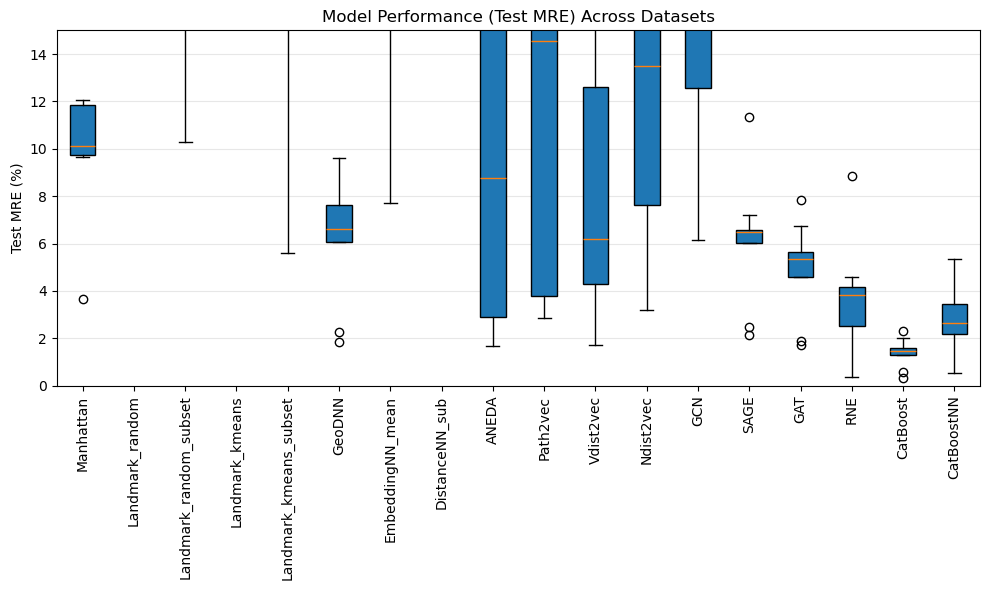

In [8]:
# Draw a box plot of model performance (test MRE) averaged across datasets

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([pivot_test_mre.loc[model].dropna().values for model in pivot_test_mre.index],
            labels=pivot_test_mre.index,
            patch_artist=True)

plt.ylabel('Test MRE (%)')
plt.title('Model Performance (Test MRE) Across Datasets')
plt.xticks(rotation=90)
plt.ylim(0, 15)  # Set y-axis limits from 0 to 50
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

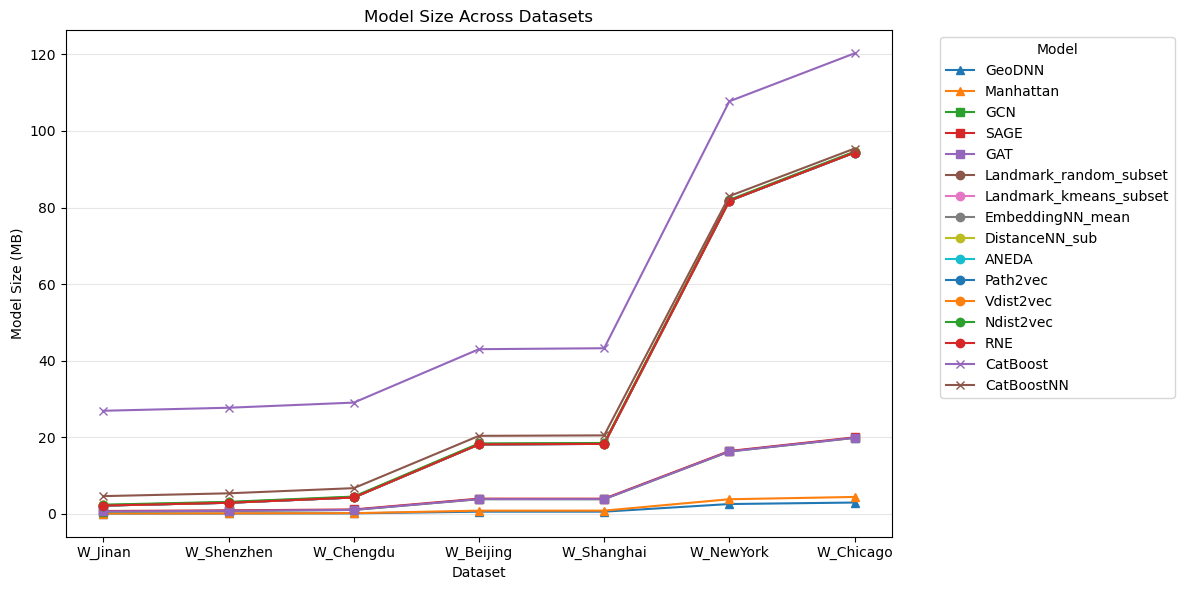

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|
| GeoDNN                 |      0.09 |         0.11 |        0.15 |        0.59 |         0.59 |        2.58 |        2.97 |
| Manhattan              |      0.1  |         0.14 |        0.2  |        0.85 |         0.86 |        3.83 |        4.43 |
| GCN                    |      0.63 |         0.8  |        1.04 |        3.86 |         3.85 |       16.3  |       19.86 |
| SAGE                   |      0.76 |         0.93 |        1.17 |        3.99 |         3.98 |       16.43 |       19.99 |
| GAT                    |      0.64 |         0.81 |        1.05 |        3.86 |         3.85 |       16.3  |       19.86 |
| Landmark_random_subset |      2.18 |         2.92 |        4.29 |       18.16 |        18.29 |       81.77 |       94.37 |


In [9]:
all_models = [
    'GeoDNN',

    'Manhattan',  # Better

    'GCN',
    'SAGE',
    'GAT',

    # 'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

markers = {
    # Category 1: coordinates only
    'GeoDNN': '^',
    'Manhattan': '^',

    # Category 2: coordinates + edges
    'GCN': 's',
    'SAGE': 's',
    'GAT': 's',

    # Category 3: embeddings only
    'EmbeddingNN': 'o',
    'EmbeddingNN_mean': 'o',
    'EmbeddingNN_sub': 'o',
    'DistanceNN': 'o',
    'DistanceNN_mean': 'o',
    'DistanceNN_sub': 'o',
    'ANEDA': 'o',
    'ANEDA_random': 'o',
    'Path2vec': 'o',
    'Vdist2vec': 'o',
    'Ndist2vec': 'o',
    'RNE': 'o',
    'Landmark_random': 'o',
    'Landmark_random_subset': 'o',
    'Landmark_kmeans': 'o',
    'Landmark_kmeans_subset': 'o',

    # Category 4: embeddings + model
    'CatBoost': 'x',
    'CatBoostNN': 'x',
}

all_datasets = [
    'W_Jinan',      # 8.9k
    'W_Shenzhen',   # 11.9k
    'W_Chengdu',    # 17.5k
    'W_Beijing',    # 74.3k
    'W_Shanghai',   # 74.9k
    'W_NewYork',    # 334.9k
    'W_Chicago',    # 386.5k
]

# Plot
plt.figure(figsize=(12, 6))
for model in all_models:
    model_data = df[df['model_name'] == model]
    plt.plot(
        all_datasets,
        [model_data[model_data['data_name'] == d]['model_size'].mean() if not model_data[model_data['data_name'] == d].empty else None for d in all_datasets],
        marker=markers.get(model, ''),
        label=model
    )
plt.xlabel('Dataset')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Across Datasets')
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Table
pivot_model_size = (
    df[df['model_name'].isin(all_models) & df['data_name'].isin(all_datasets)]
    .groupby(['model_name', 'data_name'])['model_size']
    .mean()
    .unstack('data_name')
    .reindex(index=all_models, columns=all_datasets)
)
print(pivot_model_size.round(2).to_markdown())

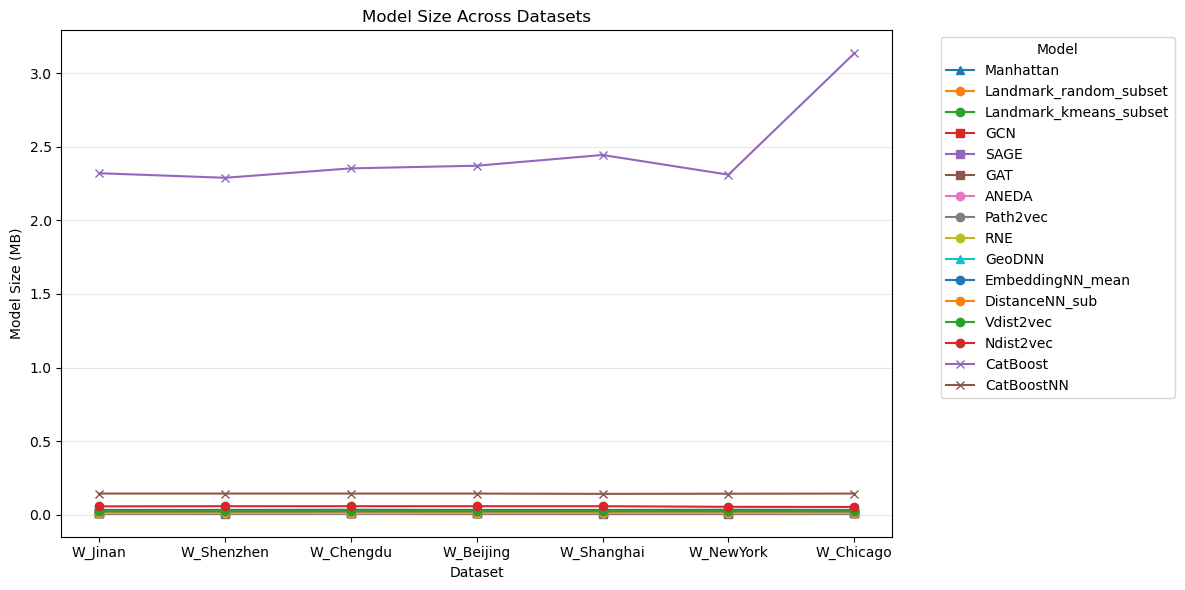

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |   Mean |   Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|-------:|------:|
| Manhattan              |     0.008 |        0.007 |       0.008 |       0.008 |        0.007 |       0.007 |       0.008 |  0.008 | 0     |
| Landmark_random_subset |     0.011 |        0.011 |       0.011 |       0.011 |        0.011 |       0.011 |       0.011 |  0.011 | 0     |
| Landmark_kmeans_subset |     0.011 |        0.011 |       0.011 |       0.011 |        0.012 |       0.012 |       0.011 |  0.011 | 0     |
| GCN                    |     0.01  |        0.01  |       0.01  |       0.009 |        0.009 |       0.009 |       0.009 |  0.009 | 0     |
| SAGE                   |     0.009 |        0.01  |       0.009 |       0.009 |        0.009 |       0.009 |       0.009 |  0.009 | 0     |
| GAT 

In [10]:
all_models = [
    'Manhattan',  # Better
    # 'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best
    'GCN',
    # 'GCN_smooth',
    'SAGE',
    # 'SAGE_smooth',
    'GAT',
    # 'GAT_smooth',
    'ANEDA',  # Better
    # 'ANEDA_random',
    'Path2vec',
    'RNE',

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'Vdist2vec',
    'Ndist2vec',


    'CatBoost',
    'CatBoostNN',
]

markers = {
    # Category 1: shallow decoder
    'Manhattan': '^',
    'Landmark_random': 'o',
    'Landmark_random_subset': 'o',
    'Landmark_kmeans': 'o',
    'Landmark_kmeans_subset': 'o',
    'GCN': 's',
    'SAGE': 's',
    'GAT': 's',
    'ANEDA': 'o',
    'ANEDA_random': 'o',
    'Path2vec': 'o',
    'RNE': 'o',

    # Category 2: neural network
    'GeoDNN': '^',
    'EmbeddingNN': 'o',
    'EmbeddingNN_mean': 'o',
    'EmbeddingNN_sub': 'o',
    'DistanceNN': 'o',
    'DistanceNN_mean': 'o',
    'DistanceNN_sub': 'o',
    'Vdist2vec': 'o',
    'Ndist2vec': 'o',

    # Category 4: embeddings + model
    'CatBoost': 'x',
    'CatBoostNN': 'x',
}

all_datasets = [
    'W_Jinan',      # 8.9k
    'W_Shenzhen',   # 11.9k
    'W_Chengdu',    # 17.5k
    'W_Beijing',    # 74.3k
    'W_Shanghai',   # 74.9k
    'W_NewYork',    # 334.9k
    'W_Chicago',    # 386.5k
]

# Plot
plt.figure(figsize=(12, 6))
for model in all_models:
    model_data = df[df['model_name'] == model]
    plt.plot(
        all_datasets,
        [model_data[model_data['data_name'] == d]['test_query_time'].mean() if not model_data[model_data['data_name'] == d].empty else None for d in all_datasets],
        marker=markers.get(model, ''),
        label=model
    )
plt.xlabel('Dataset')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Across Datasets')
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Table
pivot_test_query_time = (
    df[df['model_name'].isin(all_models) & df['data_name'].isin(all_datasets)]
    .groupby(['model_name', 'data_name'])['test_query_time']
    .mean()
    .unstack('data_name')
    .reindex(index=all_models, columns=all_datasets)
)
# Add mean and std columns across datasets
pivot_test_query_time['Mean'] = pivot_test_query_time.mean(axis=1)
pivot_test_query_time['Std'] = pivot_test_query_time.std(axis=1)
# print(pivot_test_query_time[['Mean', 'Std']].round(3).to_markdown())
print(pivot_test_query_time.round(3).to_markdown())

In [ ]:
# CPU
| model_name             |    Mean |   Std |
|:-----------------------|--------:|------:|
| Manhattan              |   0.189 |     0 |
| Landmark_random_subset |   0.408 |     0 |
| Landmark_kmeans_subset |   0.405 |     0 |
| HCL                    |   7.966 | 3.816 |
| GCN                    |   0.647 |     0 |
| SAGE                   |   0.649 |     0 |
| GAT                    |   0.722 |     0 |
| ANEDA                  |   0.551 |     0 |
| Path2vec               |   0.524 |     0 |
| RNE                    |   0.392 |     0 |
| GeoDNN                 |   0.655 |     0 |
| EmbeddingNN_mean       |   3.308 |     0 |
| DistanceNN_sub         |   0.702 |     0 |
| Vdist2vec              |   1.331 |     0 |
| Ndist2vec              |   4.237 |     0 |
| CatBoost               |   2.127 |     0 |
| LandmarkNN             |  28.252 |     0 |

# CUDA
| model_name             |   Mean |   Std |
|:-----------------------|-------:|------:|
| Manhattan              |  0.008 | 0     |
| Landmark_random_subset |  0.011 | 0     |
| Landmark_kmeans_subset |  0.011 | 0     |
| GCN                    |  0.009 | 0     |
| SAGE                   |  0.009 | 0     |
| GAT                    |  0.009 | 0     |
| ANEDA                  |  0.013 | 0     |
| Path2vec               |  0.013 | 0     |
| RNE                    |  0.011 | 0     |
| GeoDNN                 |  0.023 | 0.001 |
| EmbeddingNN_mean       |  0.032 | 0     |
| DistanceNN_sub         |  0.020 | 0     |
| Vdist2vec              |  0.023 | 0     |
| Ndist2vec              |  0.056 | 0.002 |
| CatBoost               |  2.461 | 0.279 |
| LandmarkNN             |  0.143 | 0.001 |

# Combined
| model_name             |   CPU (Mean ± Std) |   GPU (Mean ± Std) |
|:-----------------------|:-------------------|:-------------------|
| Manhattan              | 0.189 ± 0          | 0.008 ± 0          |
| Landmark_random_subset | 0.408 ± 0          | 0.011 ± 0          |
| Landmark_kmeans_subset | 0.405 ± 0          | 0.011 ± 0          |
| HCL                    | 7.966 ± 3.816      |         —          |
| GCN                    | 0.647 ± 0          | 0.009 ± 0          |
| SAGE                   | 0.649 ± 0          | 0.009 ± 0          |
| GAT                    | 0.722 ± 0          | 0.009 ± 0          |
| ANEDA                  | 0.551 ± 0          | 0.013 ± 0          |
| Path2vec               | 0.524 ± 0          | 0.013 ± 0          |
| RNE                    | 0.392 ± 0          | 0.011 ± 0          |
| GeoDNN                 | 0.655 ± 0          | 0.023 ± 0.001      |
| EmbeddingNN_mean       | 3.308 ± 0          | 0.032 ± 0          |
| DistanceNN_sub         | 0.702 ± 0          | 0.020 ± 0          |
| Vdist2vec              | 1.331 ± 0          | 0.023 ± 0          |
| Ndist2vec              | 4.237 ± 0          | 0.056 ± 0.002      |
| CatBoost               | 2.127 ± 0          | 2.461 ± 0.279      |
| LandmarkNN             | 28.252 ± 0         | 0.143 ± 0.001      |

In [12]:
sample_text = """
| model_name             |   CPU (Mean ± Std) |   GPU (Mean ± Std) |
|:-----------------------|:-------------------|:-------------------|
| Manhattan              | 0.189 ± 0          | 0.008 ± 0          |
| Landmark_random_subset | 0.408 ± 0          | 0.011 ± 0          |
| Landmark_kmeans_subset | 0.405 ± 0          | 0.011 ± 0          |
| HCL                    | 7.966 ± 3.816      |         —          |
| GCN                    | 0.647 ± 0          | 0.009 ± 0          |
| SAGE                   | 0.649 ± 0          | 0.009 ± 0          |
| GAT                    | 0.722 ± 0          | 0.009 ± 0          |
| ANEDA                  | 0.551 ± 0          | 0.013 ± 0          |
| Path2vec               | 0.524 ± 0          | 0.013 ± 0          |
| RNE                    | 0.392 ± 0          | 0.011 ± 0          |
| GeoDNN                 | 0.655 ± 0          | 0.023 ± 0.001      |
| EmbeddingNN_mean       | 3.308 ± 0          | 0.032 ± 0          |
| DistanceNN_sub         | 0.702 ± 0          | 0.020 ± 0          |
| Vdist2vec              | 1.331 ± 0          | 0.023 ± 0          |
| Ndist2vec              | 4.237 ± 0          | 0.056 ± 0.002      |
| CatBoost               | 2.127 ± 0          | 2.461 ± 0.279      |
| LandmarkNN             | 28.252 ± 0         | 0.143 ± 0.001      |
"""

# compute speedup  per line by dividing CPU mean by GPU mean
for line in sample_text.strip().split("\n")[2:]:
    parts = line.split("|")
    model_name = parts[1].strip()
    cpu_stats = parts[2].strip()
    gpu_stats = parts[3].strip()

    if gpu_stats == "—":
        speedup = "N/A"
    else:
        cpu_mean = float(cpu_stats.split("±")[0].strip())
        gpu_mean = float(gpu_stats.split("±")[0].strip())
        speedup = round(cpu_mean / gpu_mean, 2) if gpu_mean != 0 else "Inf"

    print(f"{model_name}: Speedup = {speedup}x")

Manhattan: Speedup = 23.62x
Landmark_random_subset: Speedup = 37.09x
Landmark_kmeans_subset: Speedup = 36.82x
HCL: Speedup = N/Ax
GCN: Speedup = 71.89x
SAGE: Speedup = 72.11x
GAT: Speedup = 80.22x
ANEDA: Speedup = 42.38x
Path2vec: Speedup = 40.31x
RNE: Speedup = 35.64x
GeoDNN: Speedup = 28.48x
EmbeddingNN_mean: Speedup = 103.37x
DistanceNN_sub: Speedup = 35.1x
Vdist2vec: Speedup = 57.87x
Ndist2vec: Speedup = 75.66x
CatBoost: Speedup = 0.86x
LandmarkNN: Speedup = 197.57x


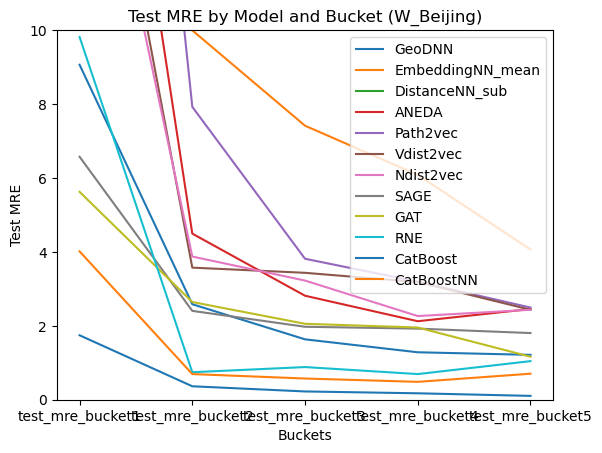

In [116]:
df[df['model_name'].isin(all_models) & df['data_name'].isin(['W_Jinan'])][['model_name', 'data_name', 'test_mre']+[c for c in df.columns if 'test_mre_bucket' in c]]

# plot all 5 buckets of test_mre for all models on W_Jinan dataset with a line plot with buckets on x-axis and test_mre on y-axis
all_models = [
    # 'Manhattan',  # Better

    # 'Landmark_random',
    # 'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    # 'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    # 'GCN_smooth',
    # 'SAGE_smooth',  # Better than SAGE
    'SAGE',
    # 'GAT_smooth',  # Better than GAT
    'GAT',

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

dataset_name = 'W_Beijing'

bucket_columns = [c for c in df.columns if 'test_mre_bucket' in c]
for model in all_models:
    model_data = df[(df['model_name'] == model) & (df['data_name'] == dataset_name)]
    plt.plot(bucket_columns, model_data[bucket_columns].values.flatten(), label=model)

plt.xlabel('Buckets')
plt.ylabel('Test MRE')
# set y-limit 0 to 15
plt.ylim(0, 10)
plt.title(f'Test MRE by Model and Bucket ({dataset_name})')
plt.legend()
plt.show()

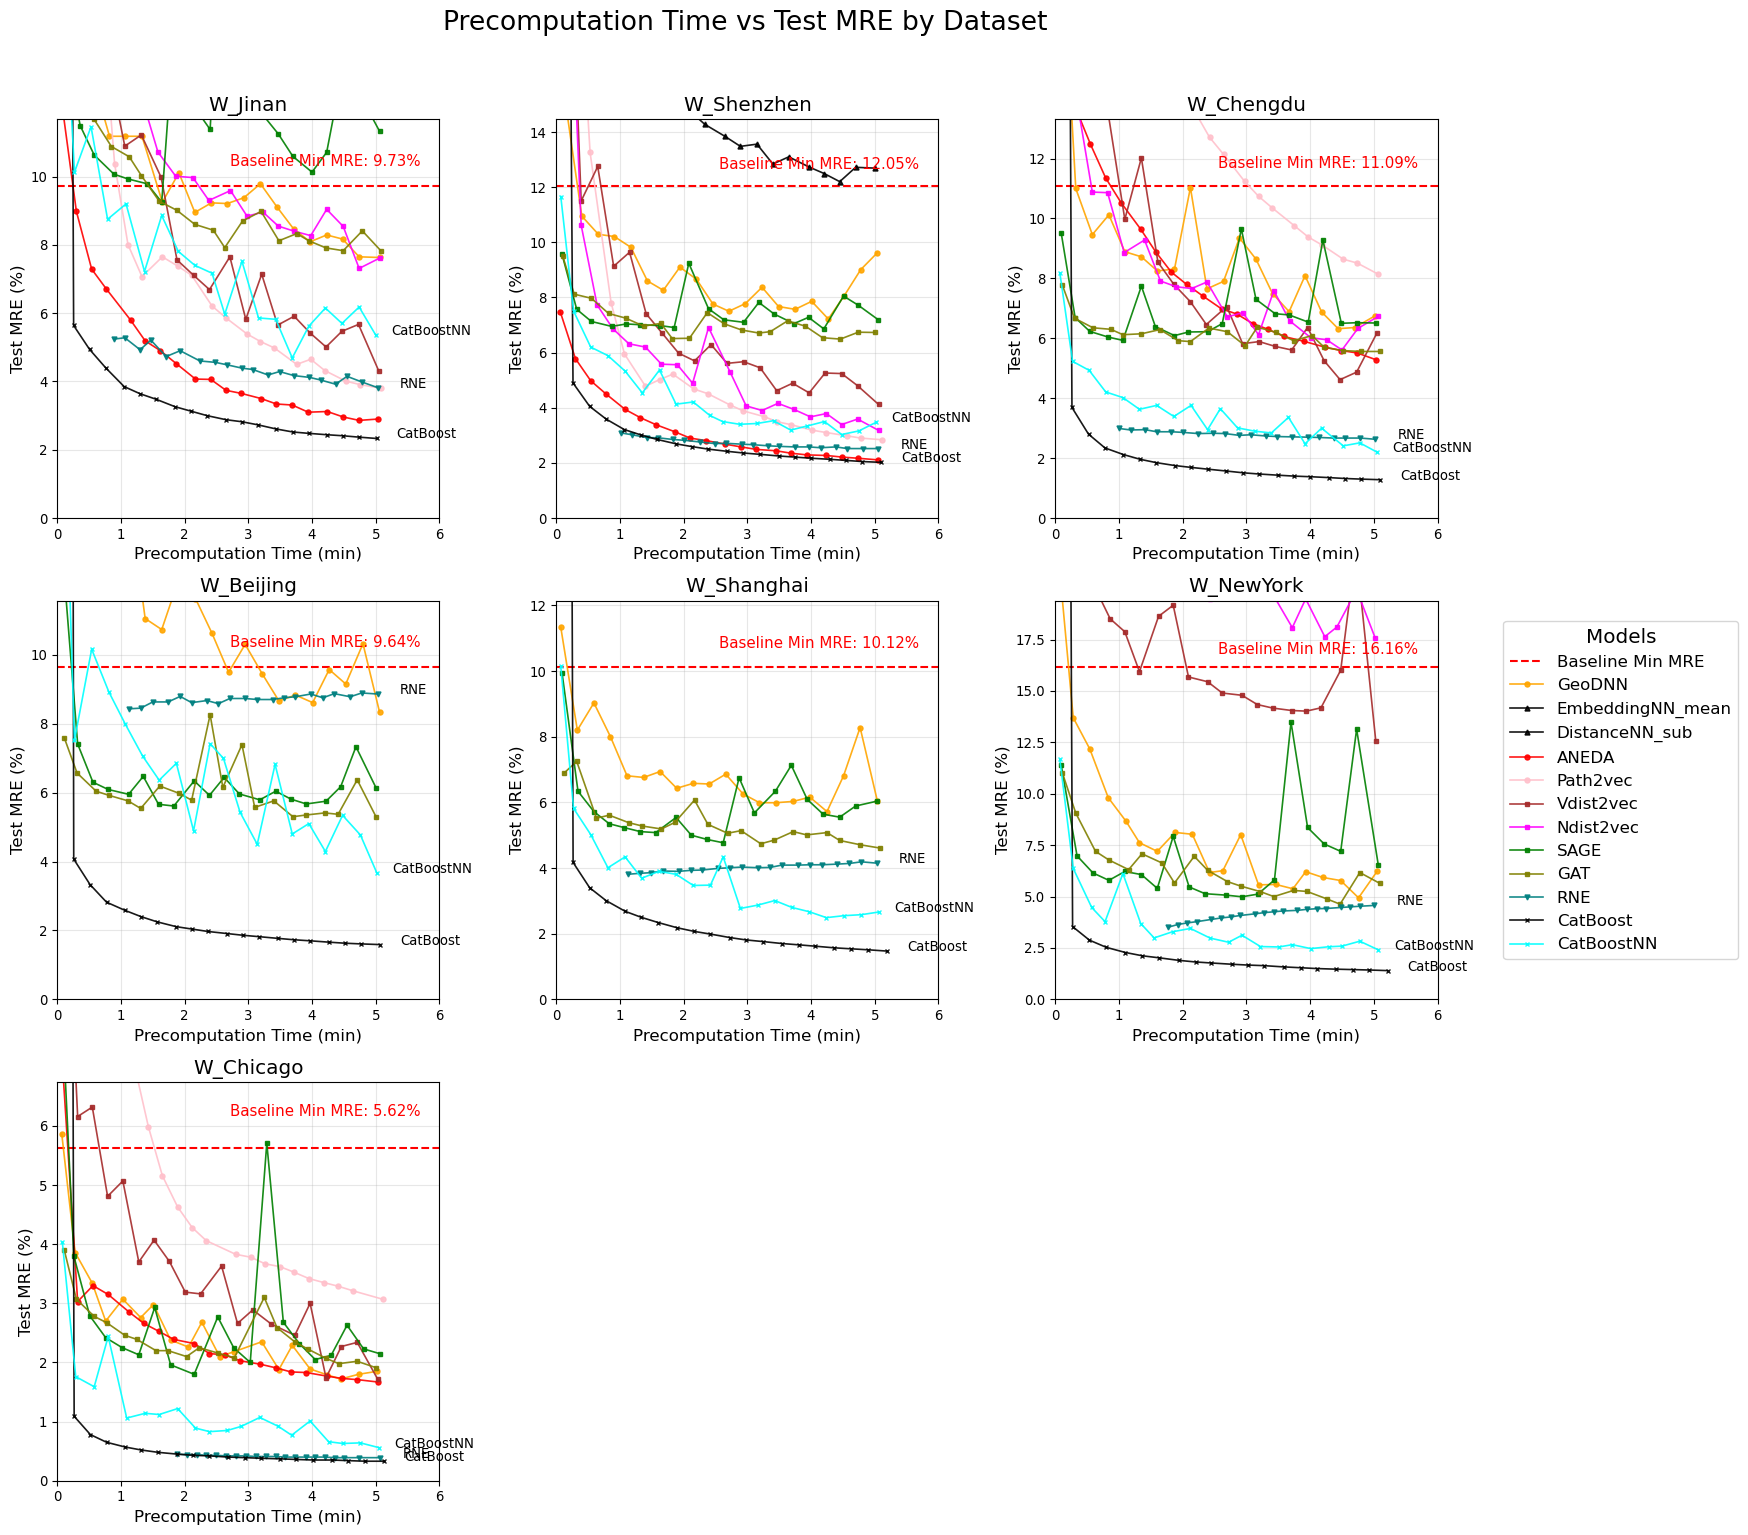

In [ ]:
# Pivot table: models as rows, datasets as columns, metric = test_mre
all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # 'GCN',
    'SAGE',
    'GAT',  # Better

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]

# Create scatter plots for precomputation time vs test MRE
def plot_precomputation_vs_mre(df, datasets, all_models, font_scale=1.5):
    # Calculate number of rows and columns for subplots
    n_datasets = len(datasets)
    n_cols = 3
    n_rows = (n_datasets + n_cols - 1) // n_cols

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Precomputation Time vs Test MRE by Dataset', fontsize=16*font_scale, y=1.02)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Define colors for different model types
    model_colors = {
        # 'Manhattan': 'gray',
        # 'Landmark': 'brown',
        'GeoDNN': 'orange',
        'EmbeddingNN': 'blue',
        'DistanceNN': 'purple',
        'ANEDA': 'red',
        'Path2vec': 'pink',
        'Vdist2vec': 'brown',
        'Ndist2vec': 'magenta',
        'SAGE': 'green',
        'GAT': 'olive',
        'RNE': 'teal',
        'CatBoost': 'black',
        'CatBoostNN': 'cyan',
    }

    markers = {
        # Category 1: coordinates only
        'GeoDNN': 'o',

        # Category 2: coordinates + edges
        'GCN': 's',
        'SAGE': 's',
        'GAT': 's',

        # Category 3: embeddings only
        'EmbeddingNN': 'o',
        'EmbeddingNN_mean': '^',
        'EmbeddingNN_sub': '^',
        'DistanceNN': '^',
        'DistanceNN_mean': '^',
        'DistanceNN_sub': '^',
        'ANEDA': 'o',
        'ANEDA_random': 'o',
        'Path2vec': 'o',
        'Vdist2vec': 's',
        'Ndist2vec': 's',
        'RNE': 'v',

        # Category 4: embeddings + model
        'CatBoost': 'x',
        'CatBoostNN': 'x',
    }

    baseline_models = ['Manhattan', 'Landmark_kmeans', 'Landmark_random', 'Landmark_kmeans_subset', 'Landmark_random_subset']

    # Plot each dataset in a separate subplot
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        data = df[df['data_name'] == dataset]

        # Add horizontal line for baseline minimum
        baseline_data = data[data['model_name'].isin(baseline_models)]
        if not baseline_data.empty:
            min_baseline_mre = baseline_data['test_mre'].min()
            if min_baseline_mre <= 25:  # Changed from 20 to 25
                ax.axhline(y=min_baseline_mre, color='red', linestyle='--', label='Baseline Min MRE')
                ax.text(0.95, min_baseline_mre + 0.5,
                       f'Baseline Min MRE: {min_baseline_mre:.2f}%',
                       color='red',
                       fontsize=9*font_scale,
                       ha='right',
                       va='bottom',
                       transform=ax.get_yaxis_transform())

        # Plot top 3 models (excluding baselines)
        # top_models = data[~data['model_name'].isin(baseline_models)].nsmallest(3, 'test_mre')
        top_models = ['CatBoostNN', 'RNE', 'CatBoost'] # Manually specify top models for consistency
        model_excluding_baselines = [m for m in all_models if m not in baseline_models]
        texts = []
        for model in model_excluding_baselines:
            model_data = data[data['model_name'] == model].iloc[0]
            model_color = model_colors.get(model, 'black')
            # Plot 'time_elapsed_history' on x-axis and 'val_mre_history' on y-axis
            # Randomly sample upto 20 evenly spaced points for plotting
            idx_sample = np.linspace(0, len(model_data['time_elapsed_history']) - 1, min(20, len(model_data['time_elapsed_history']))).astype(int)
            model_data_sampled = {
                'time_elapsed_history': np.array(model_data['time_elapsed_history'])[idx_sample],
                'val_mre_history': np.array(model_data['val_mre_history'])[idx_sample],
            }
            ax.plot(model_data_sampled['time_elapsed_history'],
                    model_data_sampled['val_mre_history'],
                    label=model_data['model_name'],
                    alpha=0.9,
                    linewidth=1*font_scale,
                    marker=markers.get(model, 'o'),
                    markersize=3*font_scale,
                    color=model_color)
            if model in top_models:
                # Annotate the point with text and collect the annotation object
                ax.annotate(model_data['model_name'],
                            (model_data_sampled['time_elapsed_history'][-1], model_data_sampled['val_mre_history'][-1]),
                            textcoords="offset points",
                            # xytext=(0, 0),
                            xytext=(20 + len(model_data['model_name'])*2, 0),
                            ha='center',
                            fontsize=8*font_scale)

        # Add labels and title
        ax.set_xlabel('Precomputation Time (min)', fontsize=10*font_scale)
        ax.set_ylabel('Test MRE (%)', fontsize=10*font_scale)
        ax.set_title(f'{dataset}', fontsize=12*font_scale)

        # Set tick label sizes
        ax.tick_params(axis='both', labelsize=8*font_scale)

        # Add grid
        ax.grid(True, alpha=0.3)

        # Set axis limits
        ax.set_xlim(0, 6)
        ax.set_ylim(0, min_baseline_mre*1.2)  # Plot up to 13% MRE for better visibility

    # Remove empty subplots
    for idx in range(len(datasets), len(axes)):
        fig.delaxes(axes[idx])

    # Add legend outside of subplots
    handles, labels = axes[0].get_legend_handles_labels()
    legend = fig.legend(handles, labels,
                       loc='center left',
                       bbox_to_anchor=(1.0, 0.5),
                       title='Models',
                       fontsize=10*font_scale)
    legend.get_title().set_fontsize(12*font_scale)

    plt.tight_layout()
    plt.show()

# Create the plot
plot_precomputation_vs_mre(df, all_datasets, all_models, font_scale=1.2)

## Figure 2 from Paper

Saved figure to `precomputation-time-vs-error.pdf`


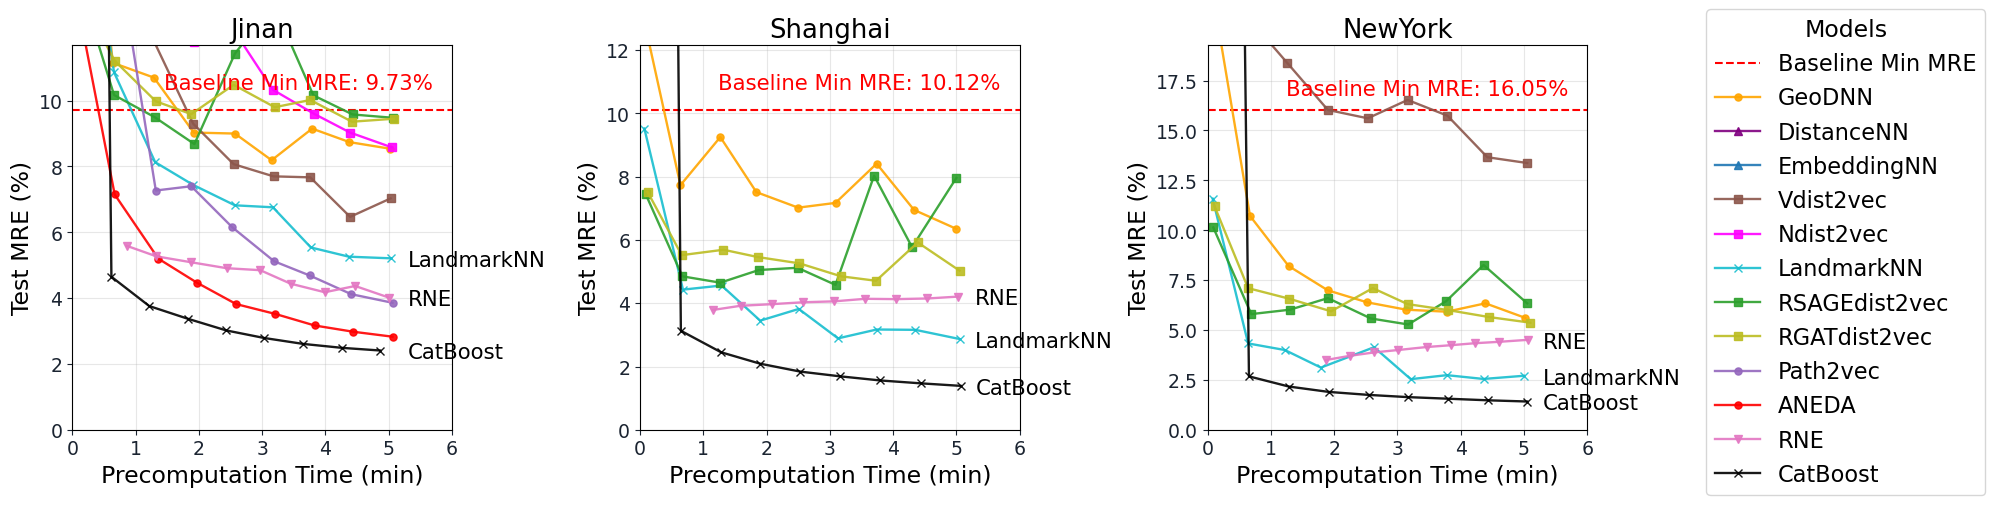

In [33]:
# Pivot table: models as rows, datasets as columns, metric = test_mre
all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    'Vdist2vec',
    'Ndist2vec',

    'CatBoostNN',

    # 'GCN',
    'SAGE',
    'GAT',  # Better

    'Path2vec',

    'ANEDA',  # Better
    # 'ANEDA_random',

    'RNE',

    'CatBoost',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    # 'W_Shenzhen',  # 11.9k
    # 'W_Chengdu',  # 17.5k
    # 'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    # 'W_Chicago',  # 386.5k
]

def plot_precomputation_vs_mre(df, datasets, all_models, font_scale=1.5, save_path=None, dpi=100):

    # Map dataset display names
    display_names = {
        'W_Jinan': 'Jinan',
        'W_Shanghai': 'Shanghai',
        'W_NewYork': 'NewYork',
        'CatBoostNN': 'LandmarkNN',
        'EmbeddingNN_mean': 'EmbeddingNN',
        'DistanceNN_sub': 'DistanceNN',
        'GAT': 'RGATdist2vec',
        'GCN': 'RGCNdist2vec',
        'SAGE': 'RSAGEdist2vec',
    }

    # Calculate number of rows and columns for subplots
    n_datasets = len(datasets)
    n_cols = 3
    n_rows = (n_datasets + n_cols - 1) // n_cols

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(17, 5*n_rows))
    # Suppress showing the title
    # fig.suptitle('Precomputation Time vs Test MRE by Dataset', fontsize=16*font_scale, y=1.02)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Define colors for different model types
    model_colors = {
        'GeoDNN': 'orange',
        'EmbeddingNN_mean': 'tab:blue',
        'DistanceNN_sub': 'purple',
        'ANEDA': 'red',
        'Path2vec': 'tab:purple',
        'Vdist2vec': 'tab:brown',
        'Ndist2vec': 'magenta',
        'SAGE': 'tab:green',
        'GAT': 'tab:olive',
        'RNE': 'tab:pink',
        'CatBoost': 'black',
        'CatBoostNN': 'tab:cyan',
    }

    markers = {
        'GeoDNN': 'o',
        'GCN': 's',
        'SAGE': 's',
        'GAT': 's',
        'EmbeddingNN': 'o',
        'EmbeddingNN_mean': '^',
        'EmbeddingNN_sub': '^',
        'DistanceNN': '^',
        'DistanceNN_mean': '^',
        'DistanceNN_sub': '^',
        'ANEDA': 'o',
        'ANEDA_random': 'o',
        'Path2vec': 'o',
        'Vdist2vec': 's',
        'Ndist2vec': 's',
        'RNE': 'v',
        'CatBoost': 'x',
        'CatBoostNN': 'x',
    }

    baseline_models = ['Manhattan', 'Landmark_kmeans', 'Landmark_random', 'Landmark_kmeans_subset', 'Landmark_random_subset']

    # Plot each dataset in a separate subplot
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        data = df[df['data_name'] == dataset]

        # Add horizontal line for baseline minimum
        baseline_data = data[data['model_name'].isin(baseline_models)]
        min_baseline_mre = None
        if not baseline_data.empty:
            min_baseline_mre = baseline_data['test_mre'].min()
            if min_baseline_mre <= 25:
                ax.axhline(y=min_baseline_mre, color='red', linestyle='--', label='Baseline Min MRE')
                ax.text(0.95, min_baseline_mre + 0.5,
                       f'Baseline Min MRE: {min_baseline_mre:.2f}%',
                       color='red',
                       fontsize=9*font_scale,
                       ha='right',
                       va='bottom',
                       transform=ax.get_yaxis_transform())

        # Plot top 3 models (excluding baselines)
        # top_models = data[~data['model_name'].isin(baseline_models)].nsmallest(3, 'test_mre')
        top_models = ['CatBoostNN', 'RNE', 'CatBoost'] # Manually specify top models for consistency
        model_excluding_baselines = [m for m in all_models if m not in baseline_models]
        texts = []
        for model in model_excluding_baselines:
            model_data = data[data['model_name'] == model].iloc[0]
            model_color = model_colors.get(model, 'black')
            display_model_name = display_names.get(model_data['model_name'], model_data['model_name'])
            # Plot 'time_elapsed_history' on x-axis and 'val_mre_history' on y-axis
            # Randomly sample upto 9 evenly spaced points for plotting
            idx_sample = np.linspace(0, len(model_data['time_elapsed_history']) - 1, min(9, len(model_data['time_elapsed_history']))).astype(int)
            model_data_sampled = {
                'time_elapsed_history': np.array(model_data['time_elapsed_history'])[idx_sample],
                'val_mre_history': np.array(model_data['val_mre_history'])[idx_sample],
            }

            # # Smooth using Savitzky-Golay filter
            # from scipy.signal import savgol_filter
            # window_length = 8
            # if len(model_data_sampled['val_mre_history']) >= window_length:  # data length >= window size
            #     model_data_sampled['val_mre_history'] = savgol_filter(
            #         model_data_sampled['val_mre_history'], window_length=window_length, polyorder=2)

            ax.plot(model_data_sampled['time_elapsed_history'],
                    model_data_sampled['val_mre_history'],
                    label=display_model_name,
                    alpha=0.9,
                    linewidth=1*font_scale,
                    marker=markers.get(model, 'o'),
                    markersize=3*font_scale,
                    color=model_color)
            if model in top_models:
                # Annotate the point with text and collect the annotation object
                ax.annotate(display_model_name,
                            (5.3, model_data_sampled['val_mre_history'][-1]),
                            ha='left',
                            va='center_baseline',
                            fontsize=9*font_scale)

        # Add labels and title (use display name mapping)
        ax.set_xlabel('Precomputation Time (min)', fontsize=10*font_scale)
        ax.set_ylabel('Test MRE (%)', fontsize=10*font_scale)
        display_name = display_names.get(dataset, dataset)
        ax.set_title(f'{display_name}', fontsize=11*font_scale)

        # Set tick label sizes
        # ax.tick_params(axis='both', labelsize=8*font_scale)
        # Gray out the tick params change
        ax.tick_params(axis='both', labelsize=8*font_scale, colors='xkcd:dark')

        # Add grid
        ax.grid(True, alpha=0.3)

        # Set axis limits if baseline found
        if min_baseline_mre is not None:
            ax.set_xlim(0, 6)
            ax.set_ylim(0, min_baseline_mre*1.2)
            # ax.set_ylim(0, 12)

    # Remove empty subplots
    for idx in range(len(datasets), len(axes)):
        fig.delaxes(axes[idx])

    # Add legend outside of subplots
    handles, labels = axes[0].get_legend_handles_labels()
    legend = fig.legend(handles, labels,
                       loc='center left',
                       bbox_to_anchor=(1.0, 0.5),
                       title='Models',
                       fontsize=9.5*font_scale)
    legend.get_title().set_fontsize(10*font_scale)

    plt.tight_layout()
    # Save if requested, then show
    if save_path:
        fig.savefig(save_path, format='pdf', dpi=dpi, bbox_inches='tight')
        print(f"Saved figure to `{save_path}`")
    plt.show()

# Create the plot
plot_precomputation_vs_mre(df, all_datasets, all_models, font_scale=1.7, save_path='precomputation-time-vs-error.pdf')

## Plots

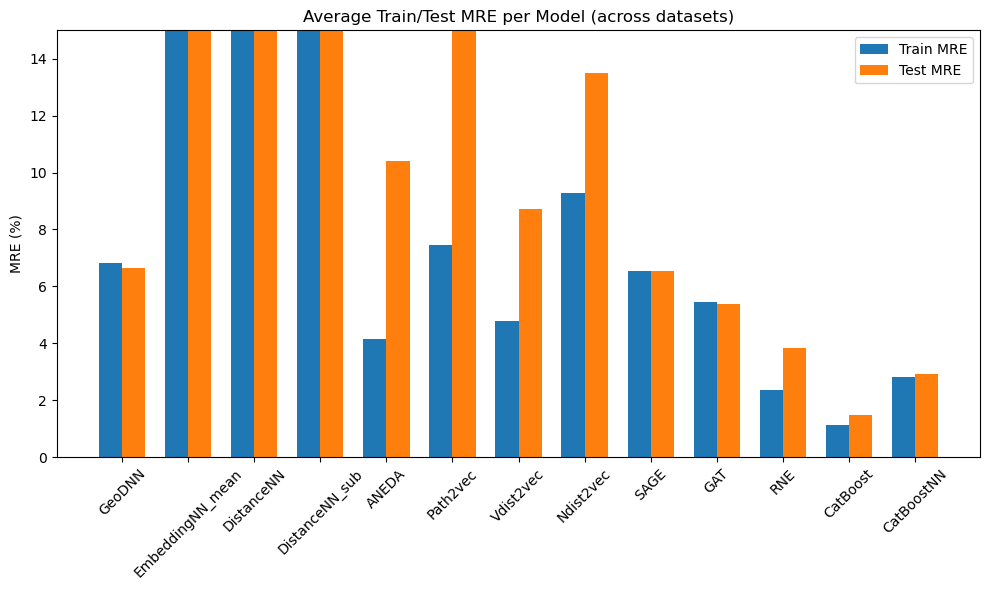

In [109]:
all_models = [
    # 'Manhattan',  # Better

    # 'Landmark_random',
    # 'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    # 'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    'SAGE',
    'GAT',  # Better than SAGE

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]

# Filter df by models
df_filtered = df[df['model_name'].isin(all_models)]

datasets = df_filtered['data_name'].unique()
models = df_filtered['model_name'].unique()

# Calculate mean train and test MRE for each model across datasets
mean_mre = df_filtered.groupby('model_name')[['train_mre', 'test_mre']].mean().loc[all_models]

x = np.arange(len(mean_mre.index))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, mean_mre['train_mre'], width=bar_width, label='Train MRE')
plt.bar(x + bar_width/2, mean_mre['test_mre'], width=bar_width, label='Test MRE')

plt.xticks(x, mean_mre.index, rotation=45)
plt.ylabel('MRE (%)')
plt.ylim(0, 15)
plt.title('Average Train/Test MRE per Model (across datasets)')
plt.legend()
plt.tight_layout()
plt.show()

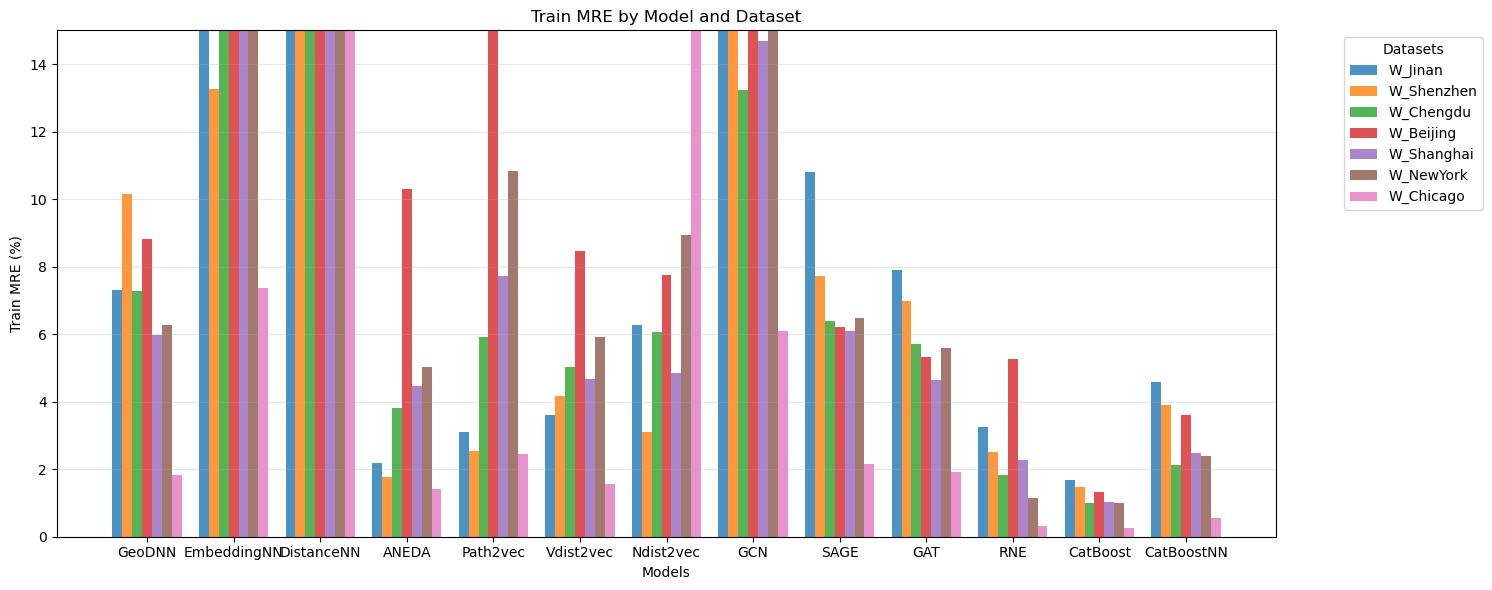

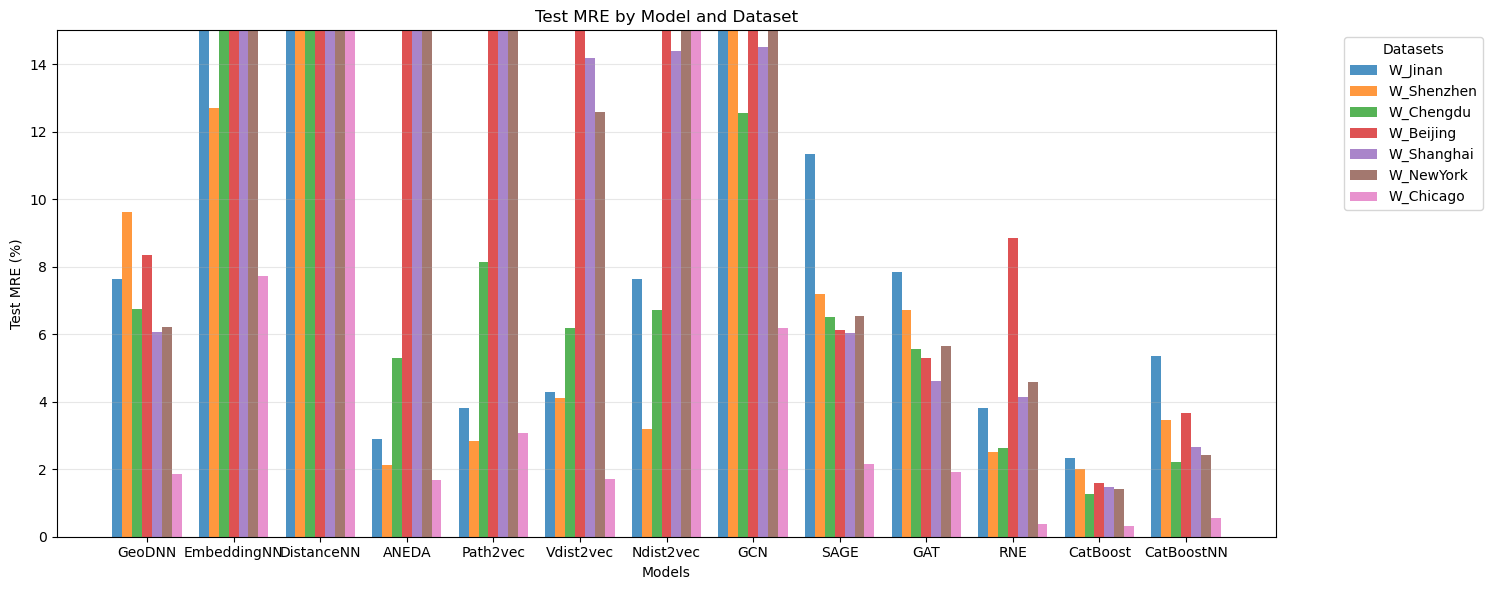

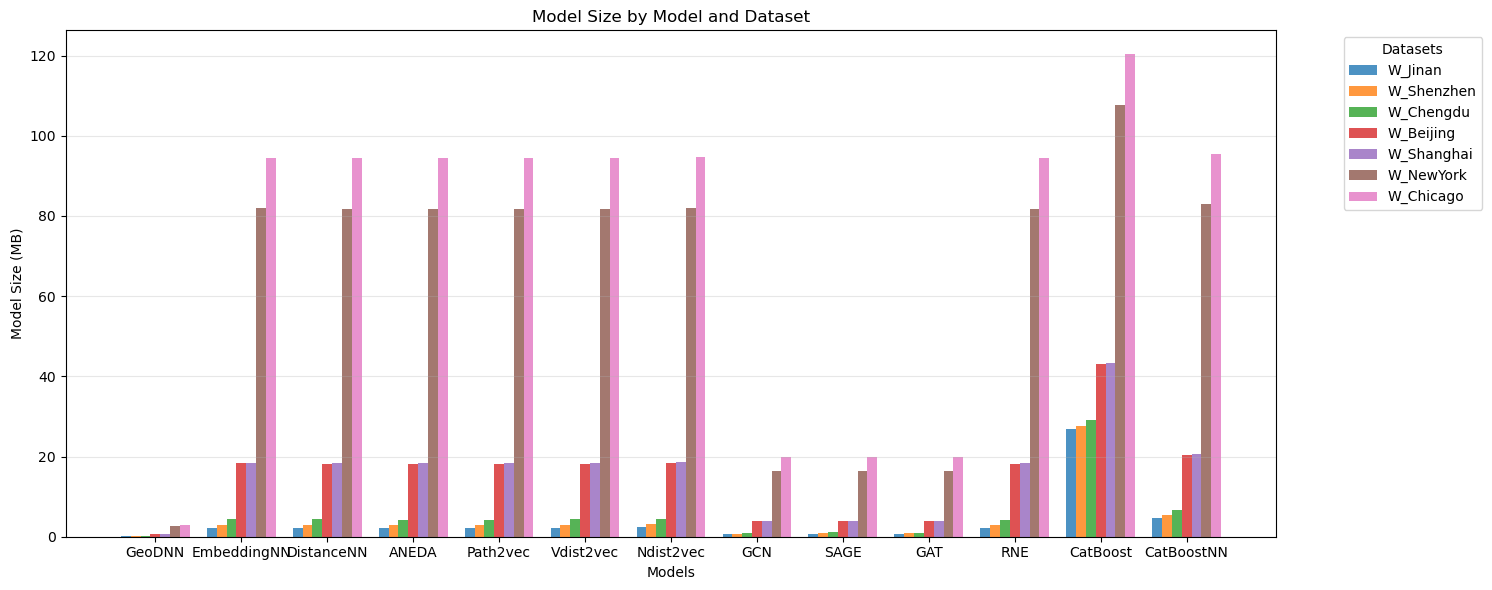

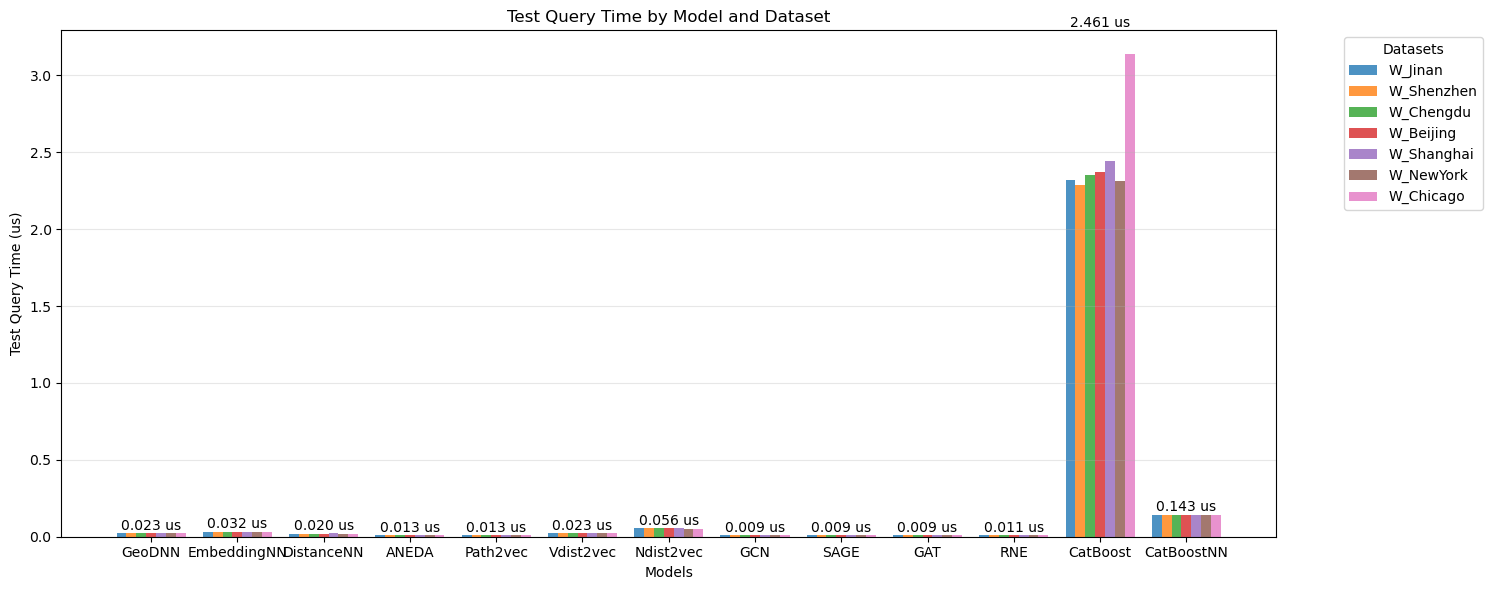

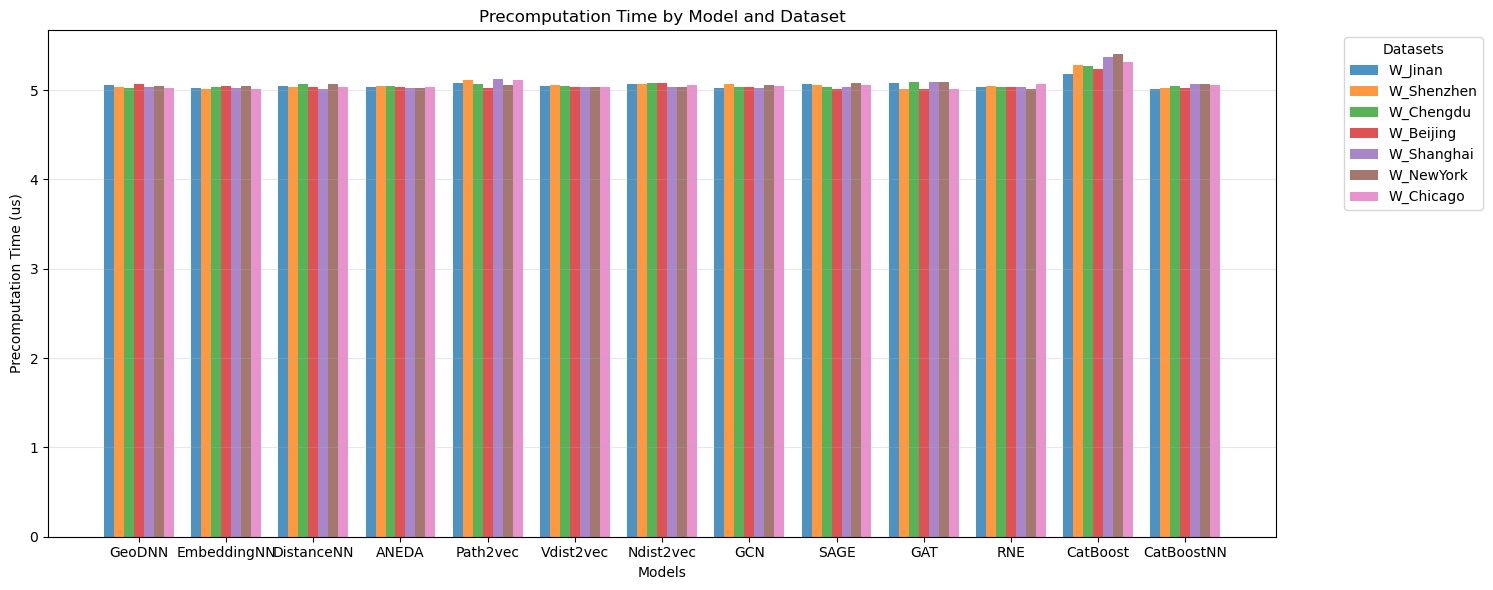

In [119]:
import numpy as np

# Keep the metrics dictionary the same
metrics = {
    'Train MRE': 'train_mre',
    'Test MRE': 'test_mre',
    'Model Size': 'model_size',
    'Test Query Time': 'test_query_time',
    'Precomputation Time': 'precomputation_time'
}
metric_units = {
    'Train MRE': '%',
    'Test MRE': '%',
    'Model Size': 'MB',
    'Test Query Time': 'us',
    'Precomputation Time': 'us'
}

all_models = [
    # 'Manhattan',  # Better

    # 'Landmark_random',
    # 'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    # 'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    'GCN',
    'SAGE',
    'GAT',  # Better than SAGE

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]

# Create grouped bar plots
def plot_metric_by_models(df, metric_name, metric_col, models, datasets):
    plt.figure(figsize=(15, 6))

    width = 0.8 / len(datasets)
    x = np.arange(len(models))

    # Store bar heights for annotation
    all_bar_heights = []

    for i, dataset in enumerate(datasets):
        values = []
        for model in models:
            val = df[(df['model_name'] == model) & (df['data_name'] == dataset)][metric_col]
            values.append(val.iloc[0] if not val.empty else np.nan)
        all_bar_heights.append(values)
        plt.bar(x + i*width - (len(datasets)-1)*width/2,
               values,
               width,
               label=dataset,
               alpha=0.8)

    # Annotate mean for each model (only for Test Query Time)
    if metric_name == 'Test Query Time':
        all_bar_heights = np.array(all_bar_heights)  # shape: (datasets, models)
        for idx, model in enumerate(models):
            # Get all bar heights for this model across datasets
            heights = all_bar_heights[:, idx]
            mean_val = np.nanmean(heights)
            max_val = np.nanmax(heights)
            xpos = x[idx]  # center of group
            # Place annotation slightly above max bar
            plt.text(xpos, max_val * 1.05, f"{mean_val:.3f} {metric_units[metric_name]}",
                     ha='center', va='bottom', fontsize=10, color='black', rotation=0)

    plt.xlabel('Models')
    plt.ylabel(f"{metric_name} ({metric_units[metric_name]})")
    plt.title(f'{metric_name} by Model and Dataset')
    modified_model_names = [m.split('_')[0] for m in models]
    plt.xticks(x, modified_model_names, rotation=0, ha='center')
    # if metric_name in ['Test Query Time']:
    #     plt.yscale('log')
    if metric_col in ['train_mre', 'test_mre']:
        plt.ylim(0, 15)
    plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Filter and plot for each metric
df_filtered = df[df['model_name'].isin(all_models)]

for metric_name, metric_col in metrics.items():
    plot_metric_by_models(df_filtered, metric_name, metric_col, all_models, all_datasets)

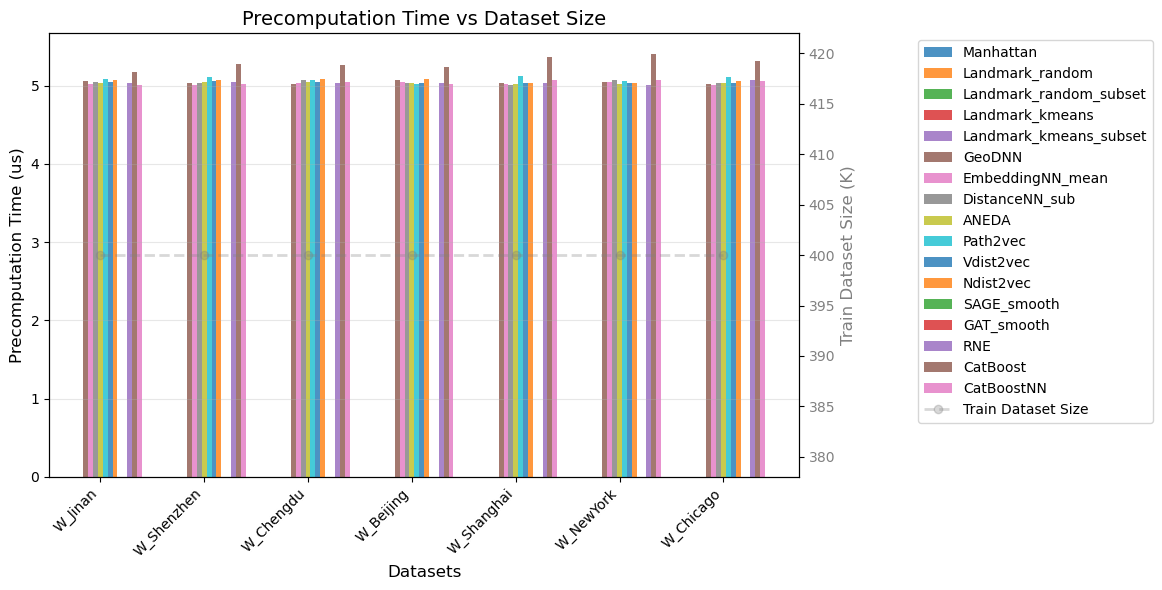

In [39]:
all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    # 'GCN_smooth',
    'SAGE_smooth',  # Better than SAGE
    # 'SAGE',
    'GAT_smooth',  # Better than GAT
    # 'GAT',

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]

def plot_metric_across_datasets(df, models, datasets, metric='precomputation_time'):
    plt.figure(figsize=(12, 6))

    # Create main axis for primary metric
    ax1 = plt.gca()

    # Calculate bar positions
    bar_width = 0.8 / len(models)  # Adjust total width to leave some space between groups
    x = np.arange(len(datasets))

    # Plot bars for each model
    for i, model in enumerate(models):
        model_data = df[df['model_name'] == model]
        # Create a DataFrame with all datasets and merge with model data to maintain order
        ordered_data = pd.DataFrame({'data_name': datasets})
        model_data = ordered_data.merge(model_data, on='data_name', how='left')

        ax1.bar(x + i*bar_width - (len(models)-1)*bar_width/2,
               model_data[metric],
               bar_width,
               label=model,
               alpha=0.8)

    # Customize primary axis
    ax1.set_xlabel('Datasets', fontsize=12)
    metric_name = metric.replace("_", " ").title()
    ax1.set_ylabel(f'{metric_name} ({metric_units[metric_name]})', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')

    # Create secondary axis for train dataset size
    ax2 = ax1.twinx()

    # Plot train dataset size as a light gray line
    data_sizes = df[['data_name', 'train_data_size']].drop_duplicates()
    # Reindex data_sizes to match dataset order
    data_sizes = pd.DataFrame({'data_name': datasets}).merge(data_sizes, on='data_name', how='left')

    ax2.plot(x,
             data_sizes['train_data_size'],
             color='gray',
             linestyle='--',
             alpha=0.3,
             linewidth=2,
             marker='o',
             label='Train Dataset Size')

    # Customize secondary axis
    ax2.set_ylabel('Train Dataset Size (K)', fontsize=12, color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
              bbox_to_anchor=(1.15, 1), loc='upper left')

    plt.title(f'{metric.replace("_", " ").title()} vs Dataset Size', fontsize=14)
    plt.tight_layout()
    plt.show()

df_filtered = df[df['model_name'].isin(all_models)]
plot_metric_across_datasets(df_filtered, all_models, all_datasets)

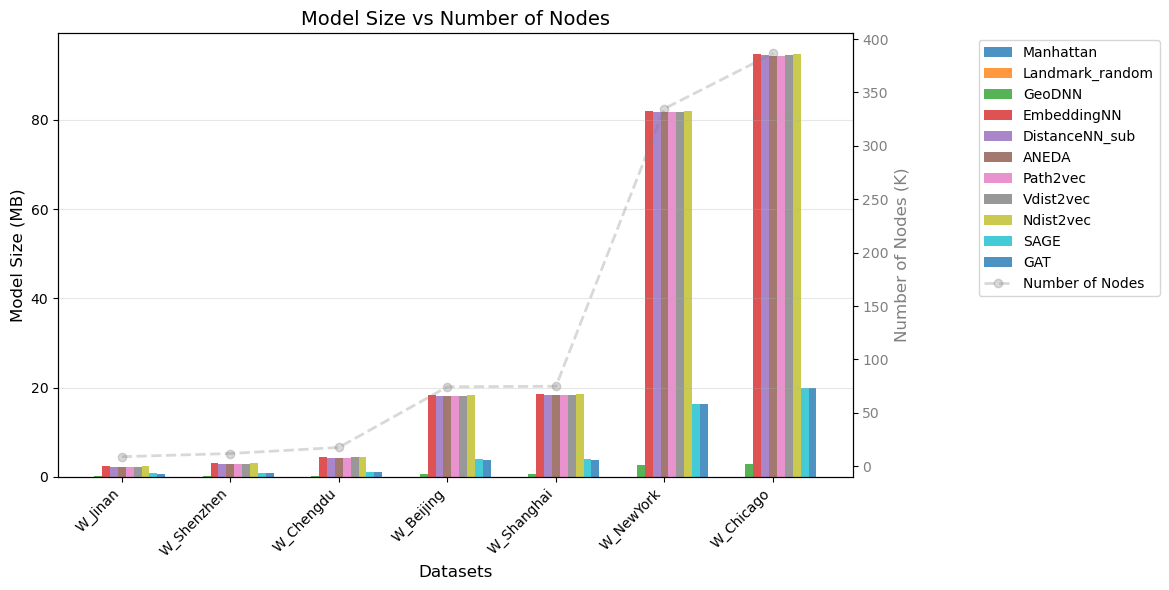

In [40]:
all_models = [
    'Manhattan',  # Better

    'Landmark_random',  # Better
    # 'Landmark_kmeans',

    'GeoDNN',

    'EmbeddingNN',  # Better
    # 'EmbeddingNN_mean',
    # 'EmbeddingNN_sub',

    # 'DistanceNN',
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random'

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    'SAGE',
    'GAT',  # Better
]

def plot_model_size_across_datasets(df, models, datasets):
    plt.figure(figsize=(12, 6))

    # Create main axis for model size
    ax1 = plt.gca()

    # Calculate bar positions
    bar_width = 0.8 / len(models)  # Adjust total width to leave some space between groups
    x = np.arange(len(datasets))

    # Plot bars for each model
    for i, model in enumerate(models):
        model_data = df[df['model_name'] == model]
        # Create a DataFrame with all datasets and merge with model data to maintain order
        ordered_data = pd.DataFrame({'data_name': datasets})
        model_data = ordered_data.merge(model_data, on='data_name', how='left')

        ax1.bar(x + i*bar_width - (len(models)-1)*bar_width/2,
               model_data['model_size'],
               bar_width,
               label=model,
               alpha=0.8)

    # Customize primary axis
    ax1.set_xlabel('Datasets', fontsize=12)
    ax1.set_ylabel('Model Size (MB)', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')

    # Create secondary axis for number of nodes
    ax2 = ax1.twinx()

    # Plot number of nodes as a line
    node_counts = df[['data_name', 'num_nodes']].drop_duplicates()
    # Reindex node_counts to match dataset order
    node_counts = pd.DataFrame({'data_name': datasets}).merge(node_counts, on='data_name', how='left')

    ax2.plot(x,
             node_counts['num_nodes'],
             color='gray',
             linestyle='--',
             alpha=0.3,
             linewidth=2,
             marker='o',
             label='Number of Nodes')

    # Customize secondary axis
    ax2.set_ylabel('Number of Nodes (K)', fontsize=12, color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
              bbox_to_anchor=(1.15, 1), loc='upper left')

    plt.title('Model Size vs Number of Nodes', fontsize=14)
    plt.tight_layout()
    plt.show()

# Filter data and plot
df_filtered = df[df['model_name'].isin(all_models)]
plot_model_size_across_datasets(df_filtered, all_models, all_datasets)

Max and min values in metric Precomputation Time (min): 5.1 MB, 5.0 MB


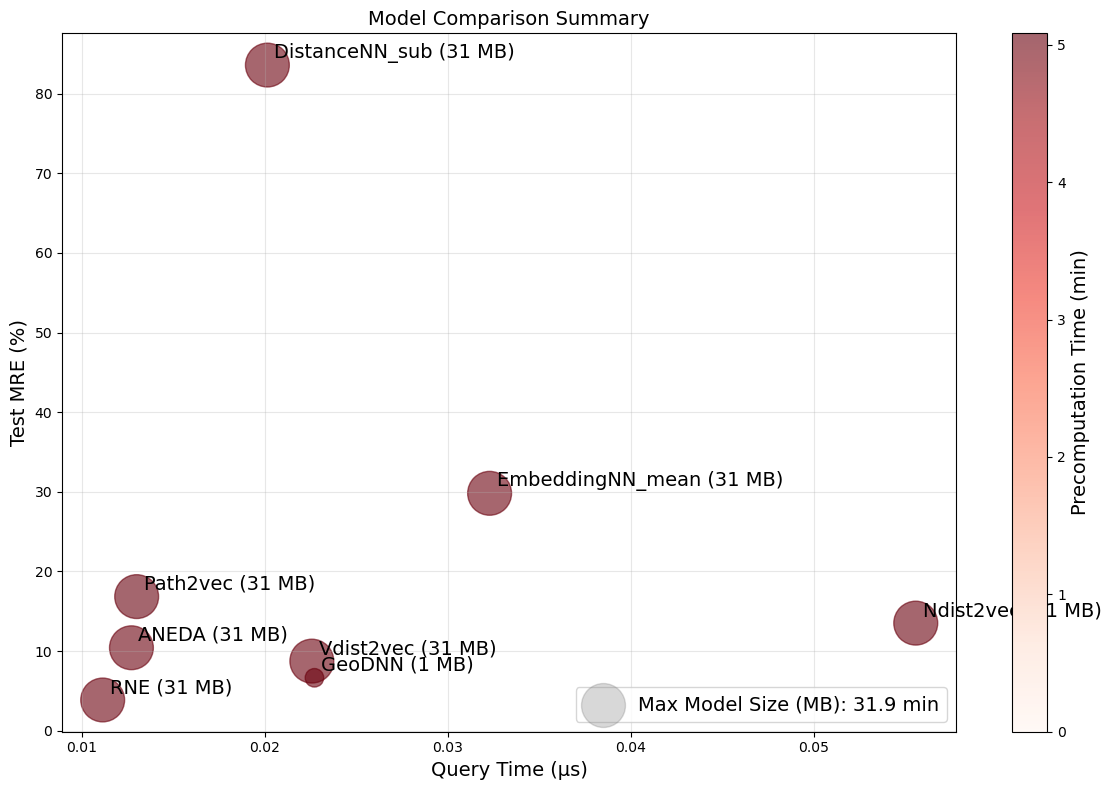


Summary of metrics:
| model_name       |   test_mre |   precomputation_time |   test_query_time |   model_size |
|:-----------------|-----------:|----------------------:|------------------:|-------------:|
| RNE              |       3.85 |                  5.04 |              0.01 |        31.71 |
| GeoDNN           |       6.64 |                  5.04 |              0.02 |         1.01 |
| Vdist2vec        |       8.73 |                  5.04 |              0.02 |        31.77 |
| ANEDA            |      10.41 |                  5.04 |              0.01 |        31.71 |
| Ndist2vec        |      13.5  |                  5.06 |              0.06 |        31.95 |
| Path2vec         |      16.83 |                  5.08 |              0.01 |        31.71 |
| EmbeddingNN_mean |      29.81 |                  5.03 |              0.03 |        31.84 |
| DistanceNN_sub   |      83.6  |                  5.04 |              0.02 |        31.73 |


In [41]:
def plot_combined_metrics(df, models):
    # Calculate mean metrics across datasets for each model
    # Dim1: x-axis
    # Dim2: y-axis
    # Dim3: size of circle
    # Dim4: color intensity

    # mean_metrics = df[df['model_name'].isin(models)].query("data_name == 'W_Chicago'")

    mean_metrics = df[df['model_name'].isin(models)].groupby('model_name').agg({
        'test_mre': 'mean',            # dim4: color intensity
        'precomputation_time': 'mean', # dim3: size of circle
        'test_query_time': 'mean',     # dim2: y-axis
        'model_size': 'mean',          # dim1: x-axis
    }).reset_index()

    plt.figure(figsize=(12, 8))


    metric_name = {
        'test_query_time': 'Query Time (μs)',
        'test_mre': 'Test MRE (%)',
        'precomputation_time': 'Precomputation Time (min)',
        'model_size': 'Model Size (MB)',
    }
    dim1 = 'test_query_time'
    dim2 = 'test_mre'
    dim3 = 'model_size'
    dim4 = 'precomputation_time'

    vmin = 0 # 0.2 * mean_metrics[dim4].max()
    vmax = mean_metrics[dim4].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    scatter = plt.scatter(mean_metrics[dim1],  # X-axis
                         mean_metrics[dim2],  # Y-axis
                         s=1000 * np.sqrt(mean_metrics[dim3] / mean_metrics[dim3].max()),  # Area of circle
                         c=mean_metrics[dim4],  # Color intensity
                         cmap='Reds',
                         alpha=0.6,
                         norm=norm)

    cbar = plt.colorbar(scatter)
    print(f"Max and min values in metric {metric_name[dim4]}: {mean_metrics[dim4].max():.1f} MB, {mean_metrics[dim4].min():.1f} MB")
    cbar.set_label(metric_name[dim4], fontsize=14)

    # Plot annotations with model name and model size in MB
    for idx, row in mean_metrics.iterrows():
        label = f"{row['model_name']} ({int(row['model_size'])} MB)"
        plt.annotate(label,
                     (row[dim1], row[dim2]),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=14,
                     )


    legend_elements = [plt.scatter([], [], s=1000,
                                 c='gray', alpha=0.3,
                                 label=f'Max {metric_name[dim3]}: {mean_metrics[dim3].max():.1f} min')]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=14)

    plt.xlabel(metric_name[dim1], fontsize=14)
    plt.ylabel(metric_name[dim2], fontsize=14)
    plt.title('Model Comparison Summary', fontsize=14)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nSummary of metrics:")
    summary_df = mean_metrics.round(2)
    summary_df = summary_df.sort_values('test_mre')
    print(summary_df.to_markdown(index=False))

# Define models to include
all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    # 'GCN_smooth',
    'SAGE_smooth',  # Better than SAGE
    # 'SAGE',
    'GAT_smooth',  # Better than GAT
    # 'GAT',

    'RNE',

    # 'CatBoost',
    # 'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]
plot_combined_metrics(df, all_models)
